In [1]:
import os
import sys

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    explanation_sensitivity,
    outcome_sensitivity,
    bootstrapped_explanation_consistency,
    cross_method_explanation_consistency,
    cross_method_outcome_consistency,
    outcome_fidelity,
)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mlresearch.utils import check_random_states, set_matplotlib_style
from sharp.utils import scores_to_ordering

RNG_SEED = 42

In [2]:
set_matplotlib_style(font_size=16, use_latex=True)

In [3]:
# # Set up ranker for the moving company dataset:
# X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
# qids_train = X.index.value_counts().to_numpy()

# model = LGBMRanker(
#     objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
# )
# model.fit(
#     X=X,
#     y=ranks,
#     group=qids_train,
# )

In [4]:
datasets = [
    {
        "name": "ATP",
        "data": preprocess_atp_data(fetch_atp_data()),
        "scorer": atp_score,
        "done": True,
    },
    {
        "name": "CSRank",
        "data": preprocess_csrank_data(fetch_csrank_data()),
        "scorer": csrank_score,
        "done": True,
    },
    {
        "name": "Higher Education",
        "data": preprocess_higher_education_data(
            fetch_higher_education_data(year=2020)
        ),
        "scorer": higher_education_score,
        "done": True,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=2, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=1, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=0, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    # {
    #     "name": "Moving Company",
    #     "data": preprocess_movers_data(fetch_movers_data(test=True)),
    #     "scorer": model.predict,
    #     "done": True,
    # },
]
xai_methods = [
    {
        "iterations": 1,
        "name": "rank_rank",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank"
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "rank_score_rank_score",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank_score"
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "pairwise_rank",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank"
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "pairwise_rank_score",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "score"
        },
        "done": True,
    },
]


In [5]:
# def read_results_from_files():
#     return_dict = {}
#     for cur_dataset in datasets:
#         return_dict[cur_dataset["name"]] = {}
#         for cur_xai_method in xai_methods:
#             return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
#             for iteration in range(cur_xai_method["iterations"]):
#                 fname = (
#                     f"results/time-experiment-"
#                     f"{cur_dataset['name']}_{cur_xai_method['name']}.csv"
#                 )
#                 if os.path.isfile(fname):
#                     (
#                         return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
#                             pd.read_csv(fname, index_col=0)
#                         )
#                     )
#     return return_dict

In [6]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/time/time-experiment-"
                    f"{cur_dataset['name']}.csv"
                )
                if os.path.isfile(fname):
                    temp = pd.read_csv(fname, index_col=0)
                    temp = temp[temp["approach"] == cur_xai_method["name"]]
                    if not temp.empty: 
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            temp
                        )
    return return_dict

In [7]:
results = read_results_from_files()

In [8]:
# results

# Make dataframe for paper plots

In [9]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

# Make new dataframe that contains everything
df_all = pd.DataFrame()

for dataset in datasets:
    # Get number of features and samples
    n_samples = dataset["data"][0].shape[0]
    n_features = dataset["data"][0].shape[1] - 1

    # Rename etc
    error = []
    # columns = ["dataset", "total samples", "QoI", "pairwise", "parameter", "# samples", "# coalitions",
    #           "time", "kendall", "jaccard", "euclidean", "fidelity"]
    columns = ["dataset", "total samples", "QoI", "pairwise", "parameter", "# samples", "# coalitions",
              "time", "distance metric", "agreement", "fidelity"]
    for method in methods:
        # Process saved file
        for index, row in results[dataset["name"]][method][0].iterrows():
            if row["approach"] == "rank_rank":
                qoi = "rank"
                pairwise = False
            elif row["approach"] == "rank_score_rank_score":
                qoi = "score"
                pairwise = False
            elif row["approach"] == "pairwise_rank":
                qoi = "rank"
                pairwise = True
            else:
                qoi = "score"
                pairwise = True
            if row["parameter"] == "coalition_size":
                samples = n_samples
                coals = row["parameter_value"]
            elif row["parameter"] == "sample_size":
                samples = row["parameter_value"]
                coals = n_features
            else:
                samples = n_samples
                coals = n_features
            for i in range(10):
                # Kendall
                error.append([row["dataset"], row["n_observations"], qoi, pairwise, row["parameter"], samples, coals,
                             row[f"time_{i}"]/ 100,"kendall's tau", row[f"agreement_kendall_{i}"], row[f"fidelity_{i}"]])
                error.append([row["dataset"], row["n_observations"], qoi, pairwise, row["parameter"], samples, coals,
                             row[f"time_{i}"]/ 100, "Jaccard Index Top-2", row[f"agreement_jaccard2_{i}"], row[f"fidelity_{i}"]])
                error.append([row["dataset"], row["n_observations"], qoi, pairwise, row["parameter"], samples, coals,
                             row[f"time_{i}"]/ 100, "Euclidean distance", row[f"agreement_euclidean_{i}"], row[f"fidelity_{i}"]])
        
        # Make dataset that contains all methods together (if run each QoI separately)
        df_all = pd.concat([df_all,pd.DataFrame(error, columns=columns)])

In [10]:
df_all

,dataset,total samples,QoI,pairwise,parameter,# samples,# coalitions,time,distance metric,agreement,fidelity
0,ATP,83,rank,False,NaN,86.0,5.0,0.024792,kendall's tau,NaN,1.0
1,ATP,83,rank,False,NaN,86.0,5.0,0.024792,Jaccard Index Top-2,NaN,1.0
2,ATP,83,rank,False,NaN,86.0,5.0,0.024792,Euclidean distance,NaN,1.0
3,ATP,83,rank,False,NaN,86.0,5.0,0.024563,kendall's tau,NaN,1.0
4,ATP,83,rank,False,NaN,86.0,5.0,0.024563,Jaccard Index Top-2,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
835,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013856,Jaccard Index Top-2,1.0,1.0
836,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013856,Euclidean distance,1.0,1.0
837,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013996,kendall's tau,1.0,1.0
838,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013996,Jaccard Index Top-2,1.0,1.0


# Coalition/Sample Size vs Metrics

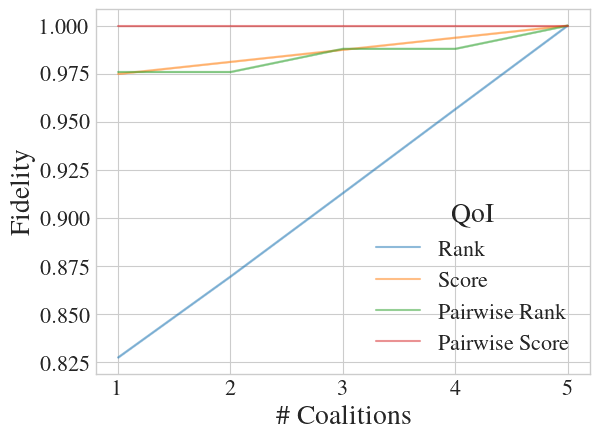

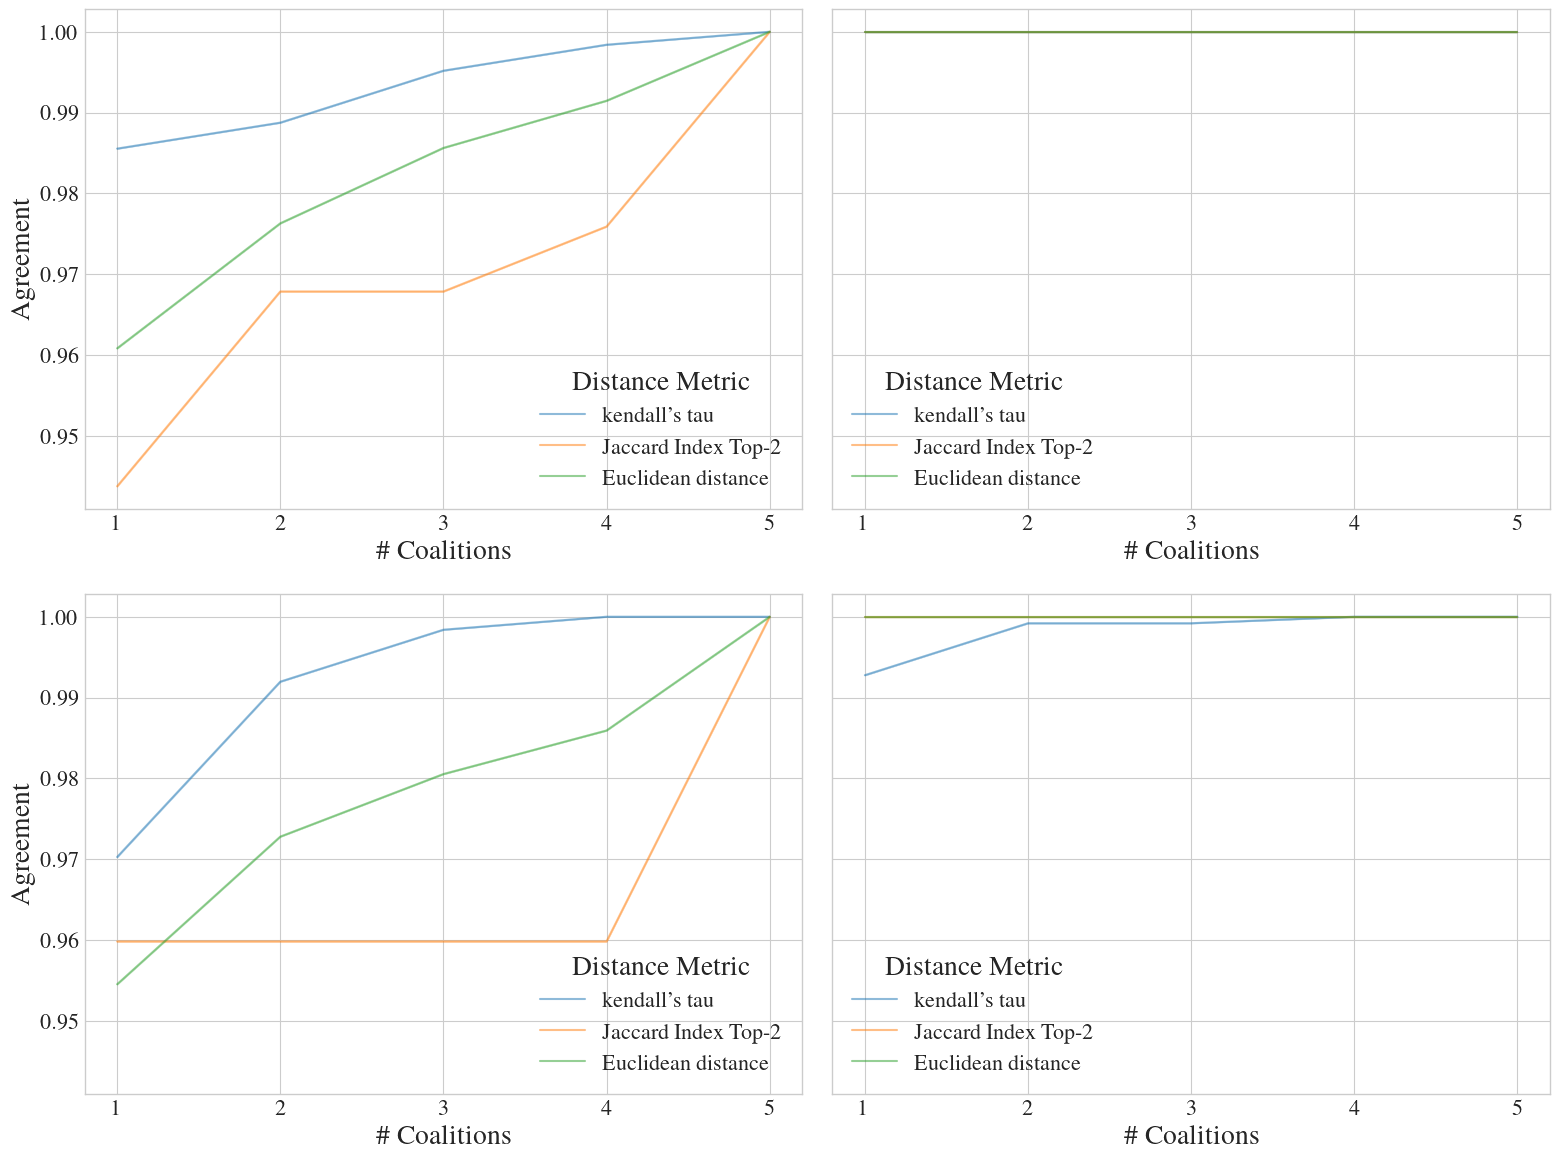

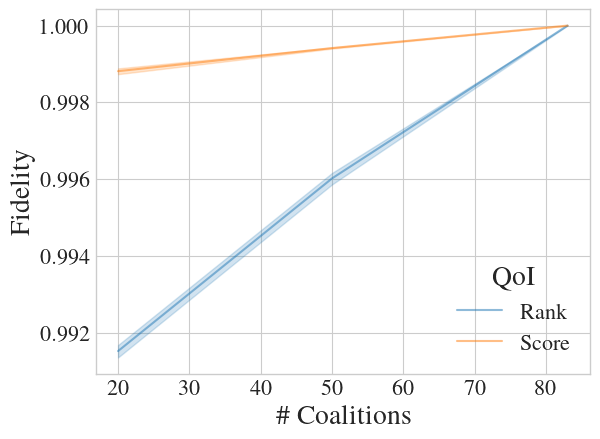

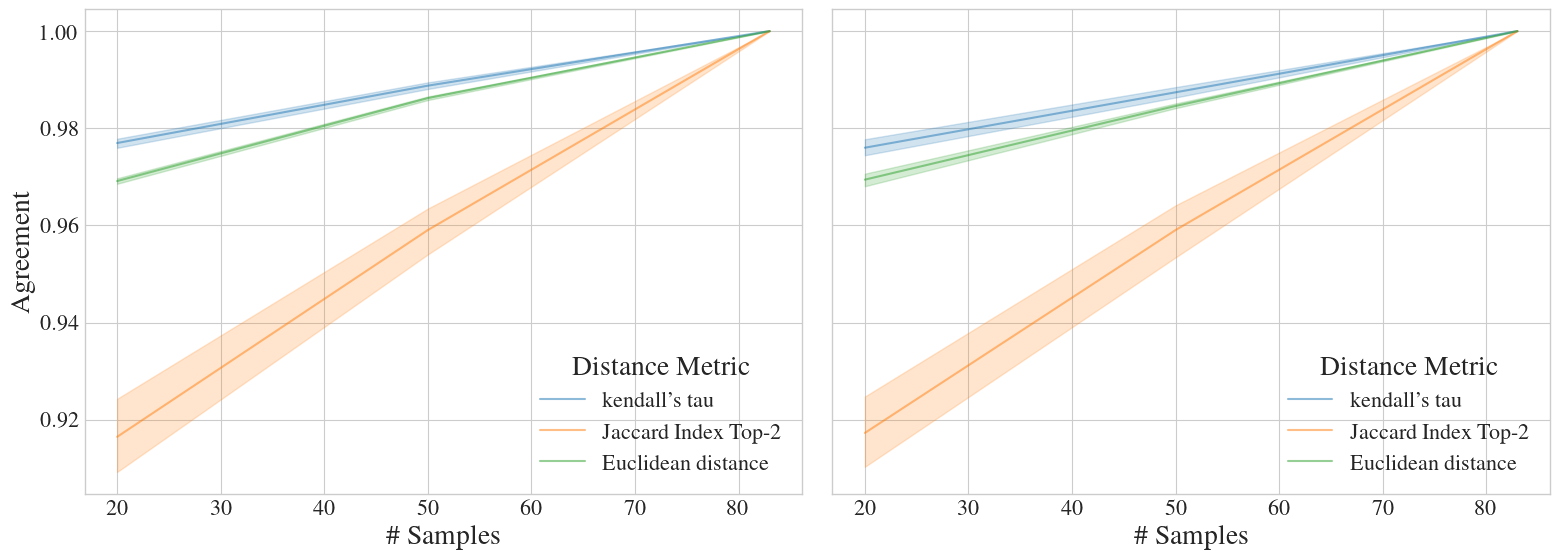

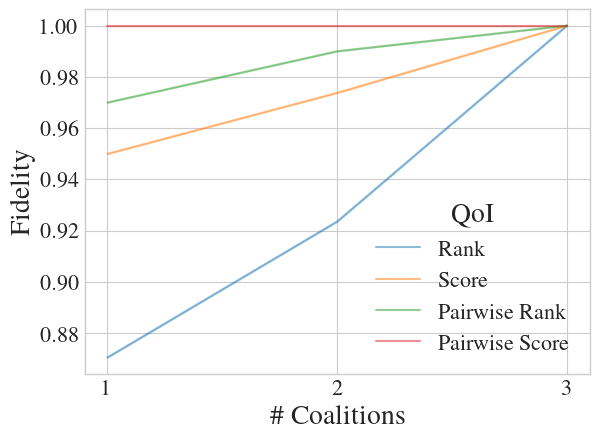

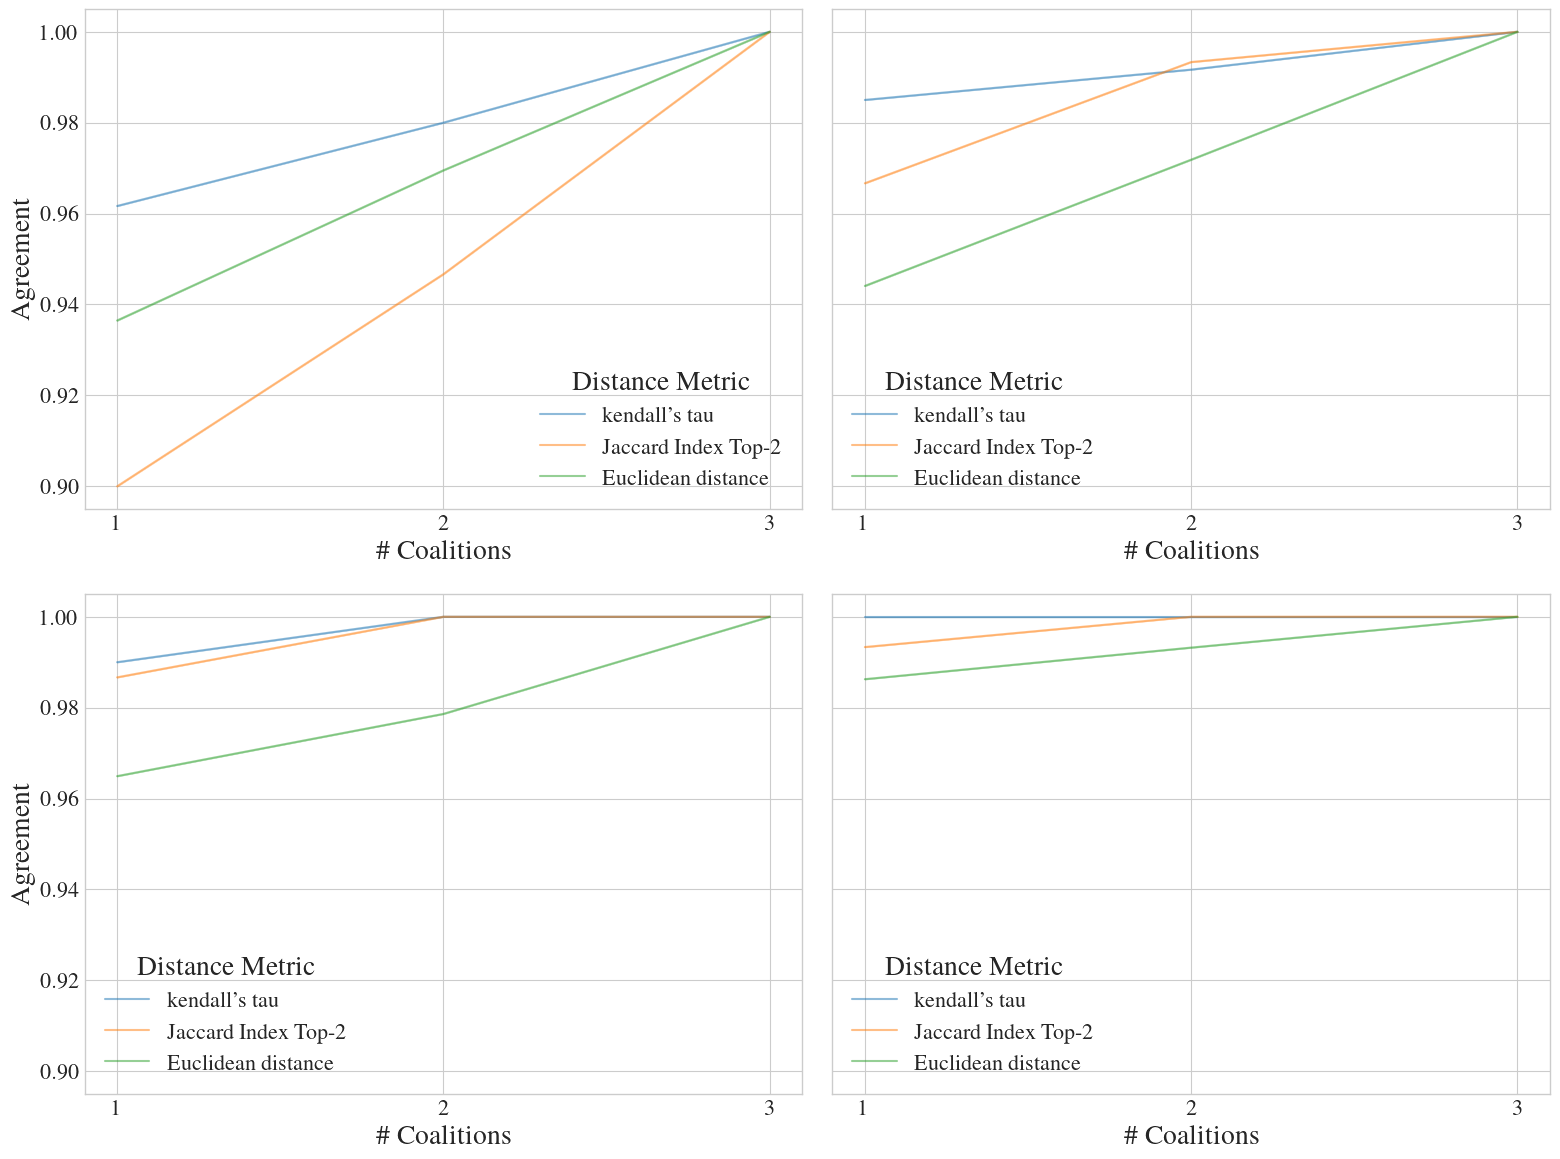

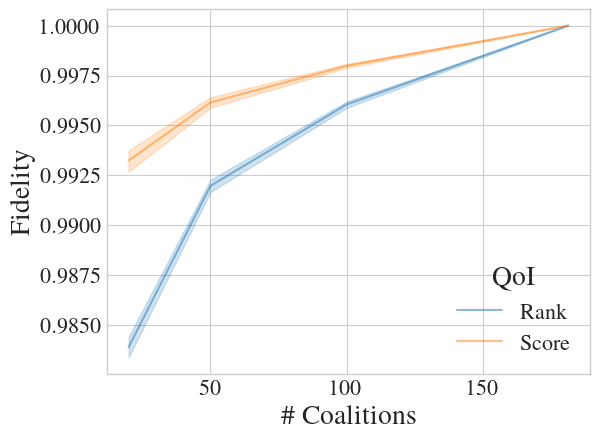

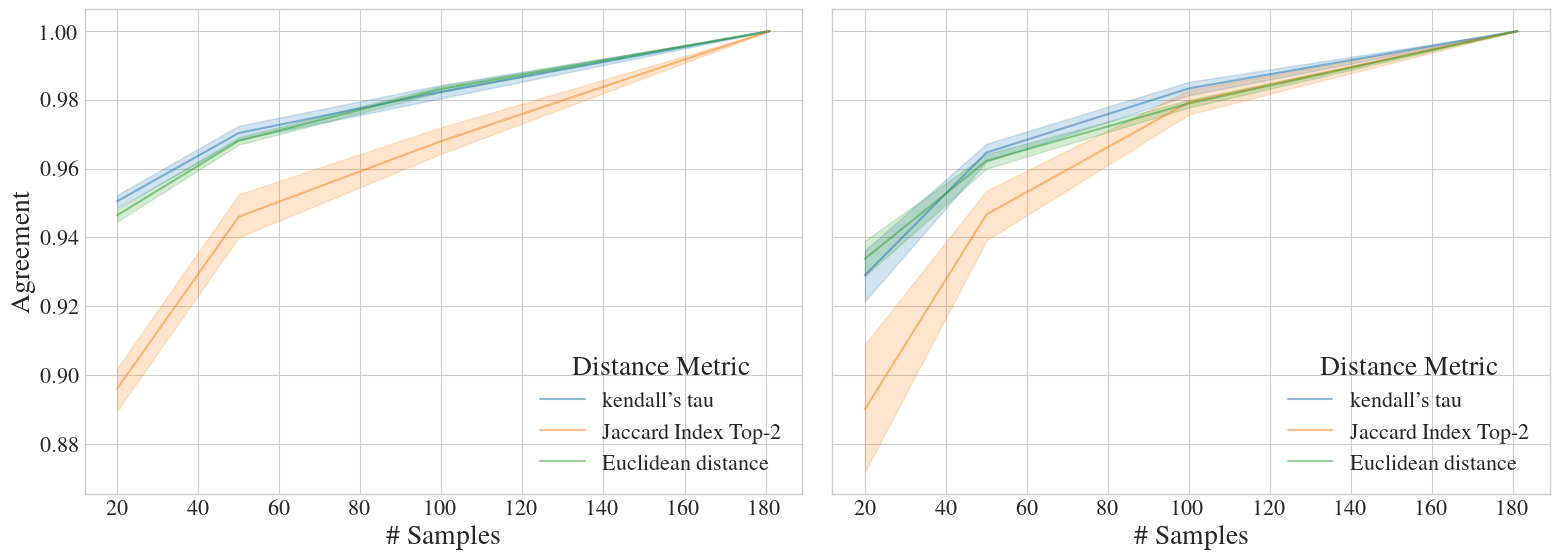

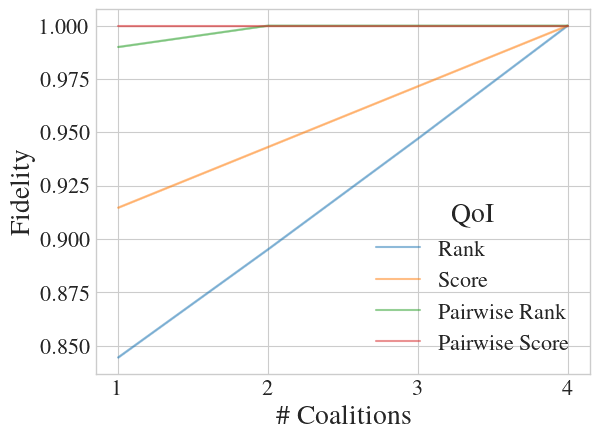

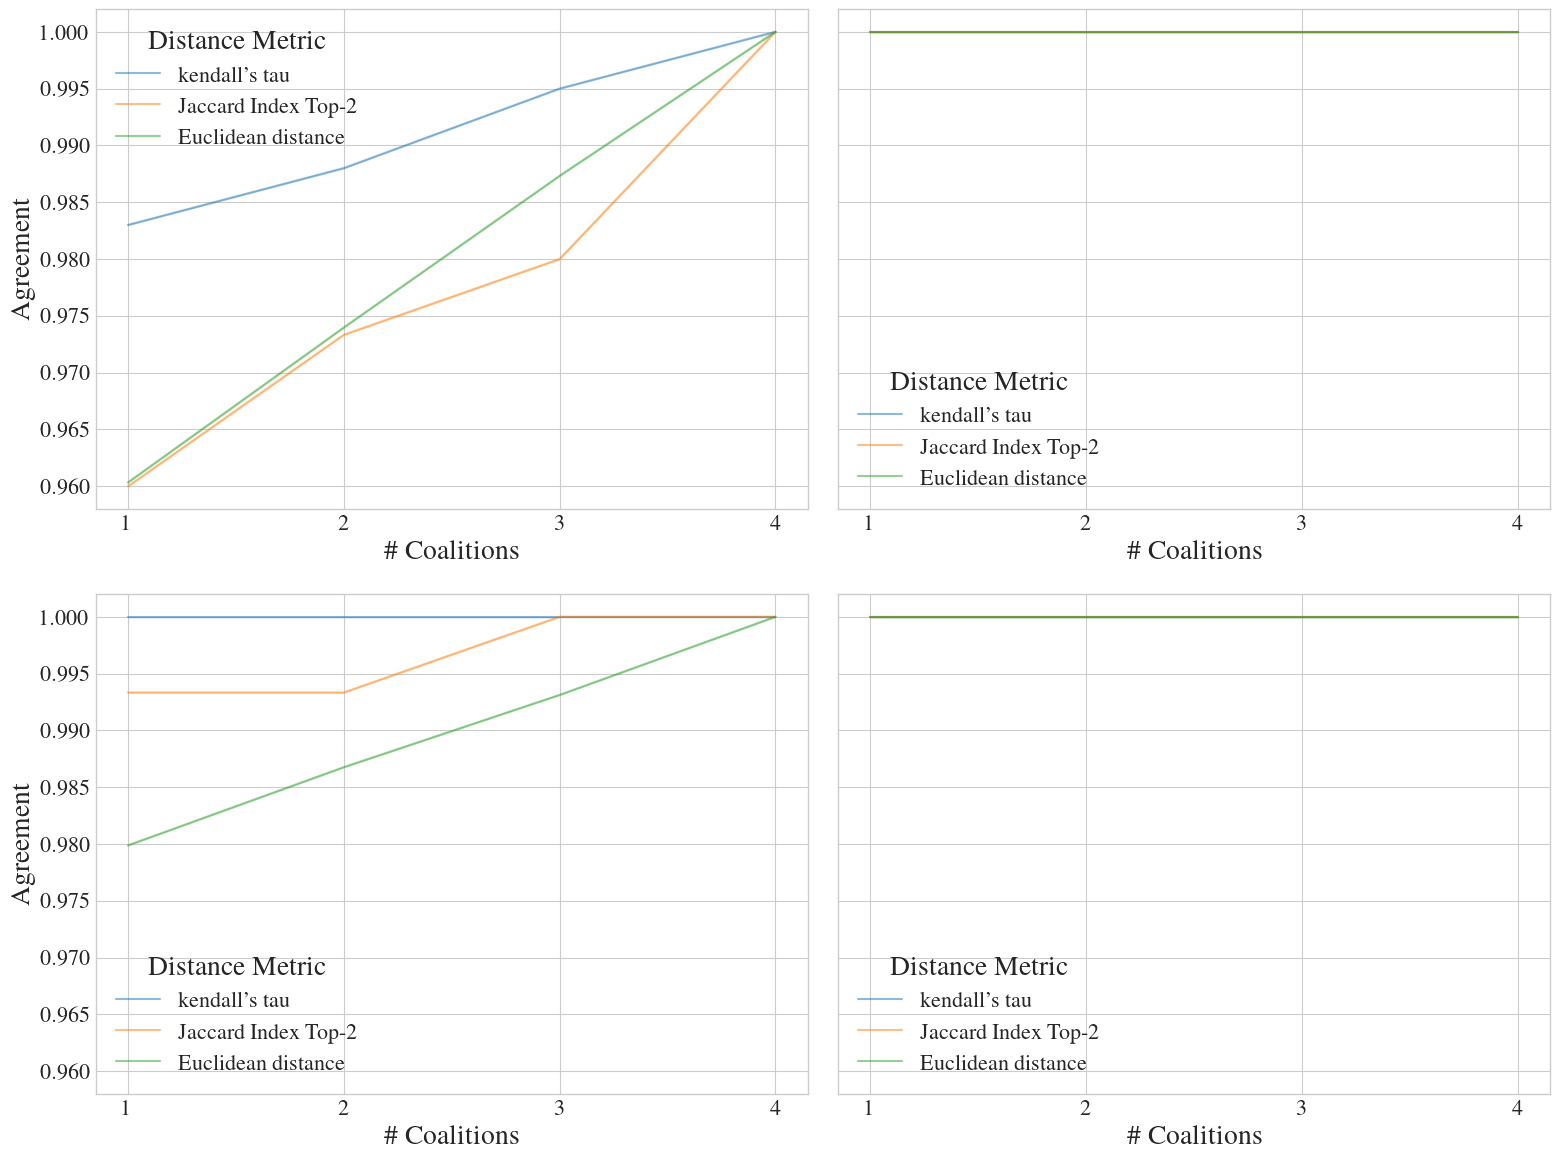

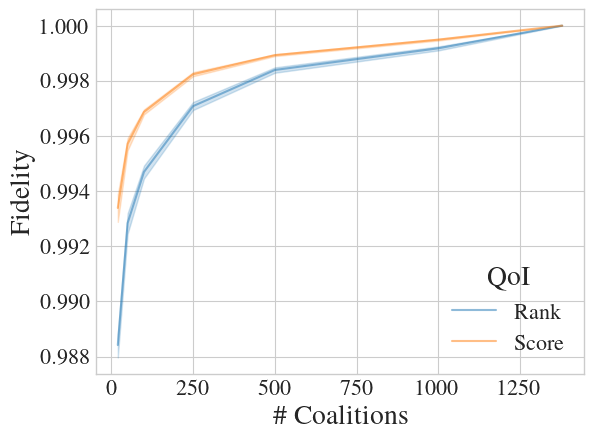

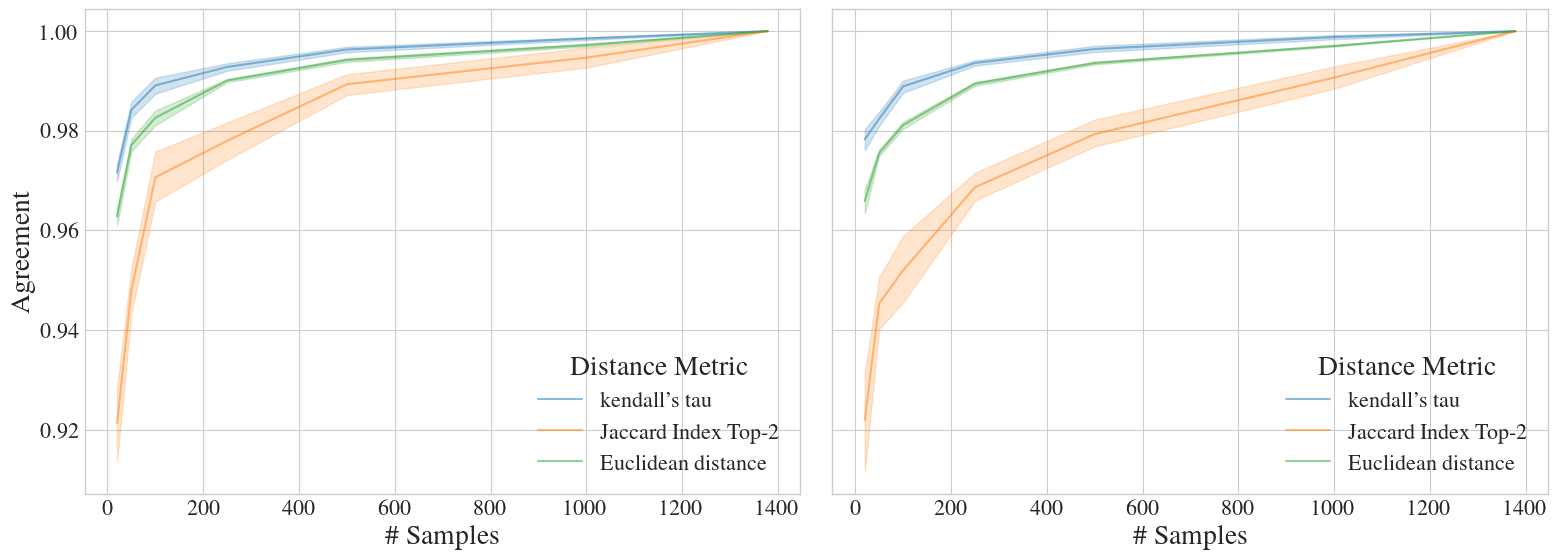

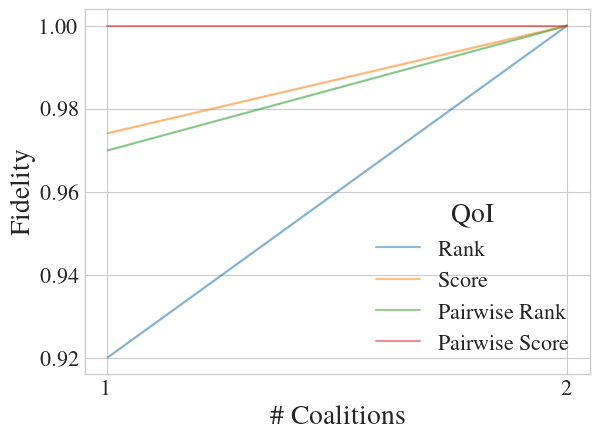

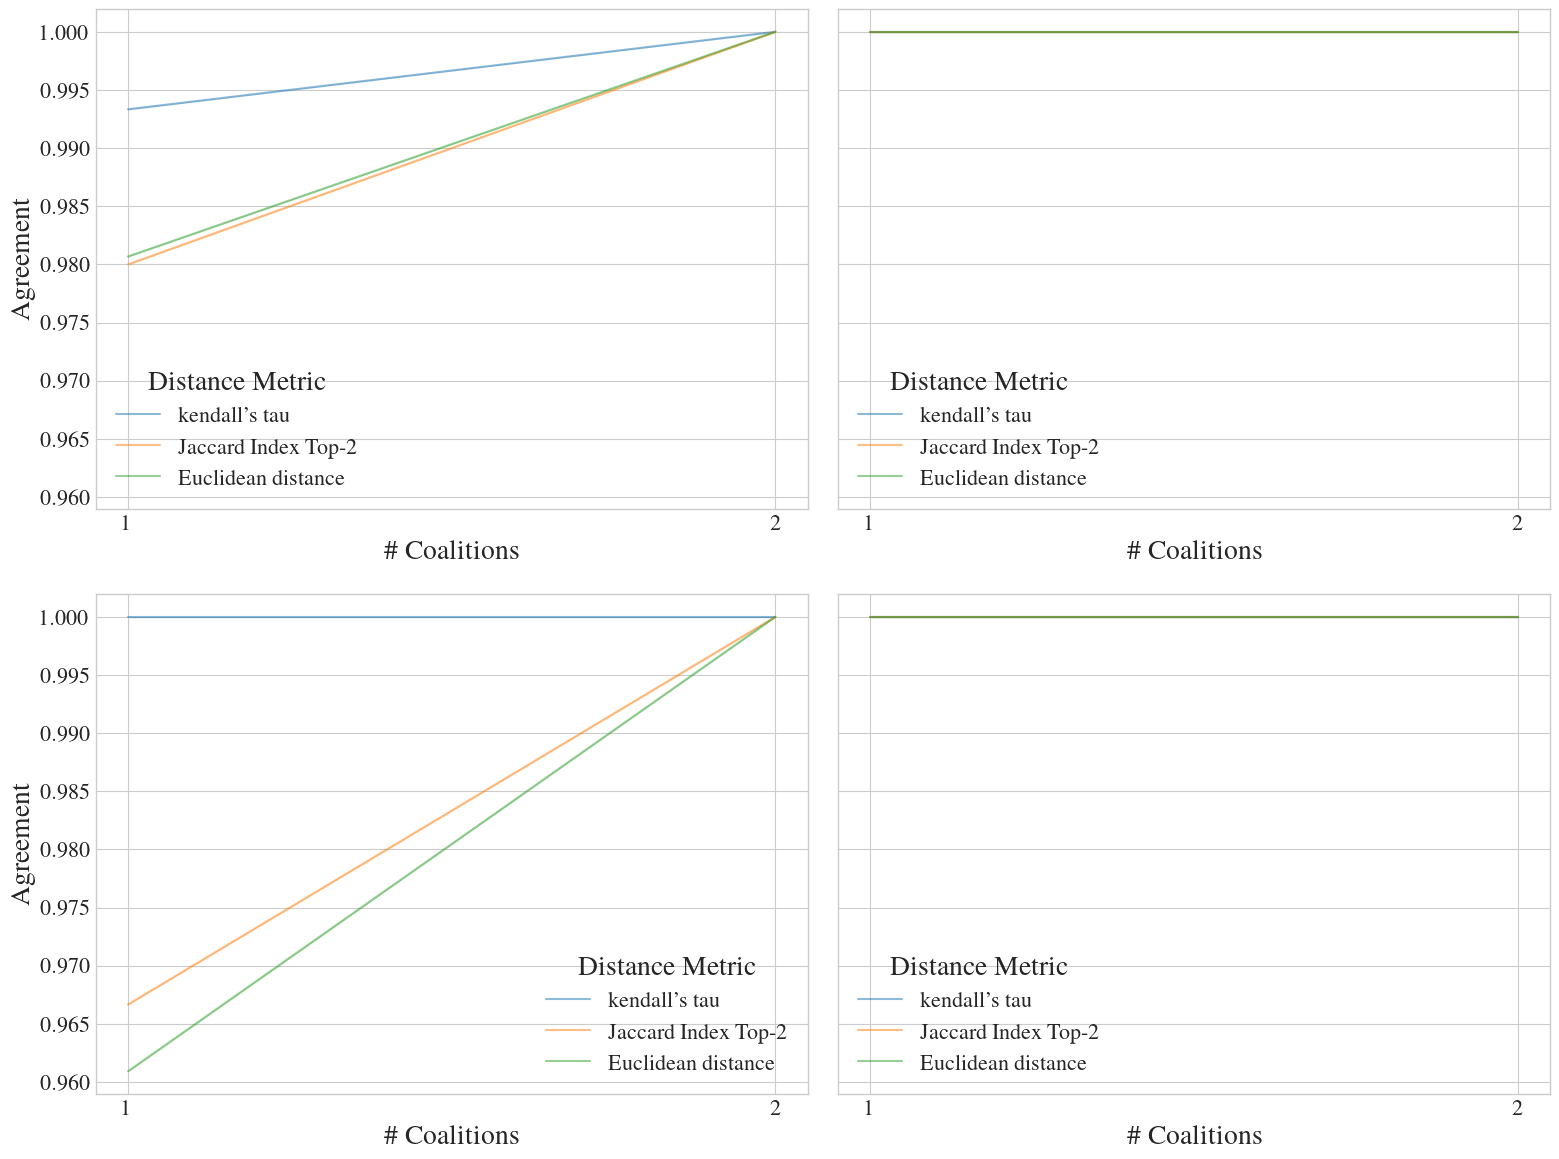

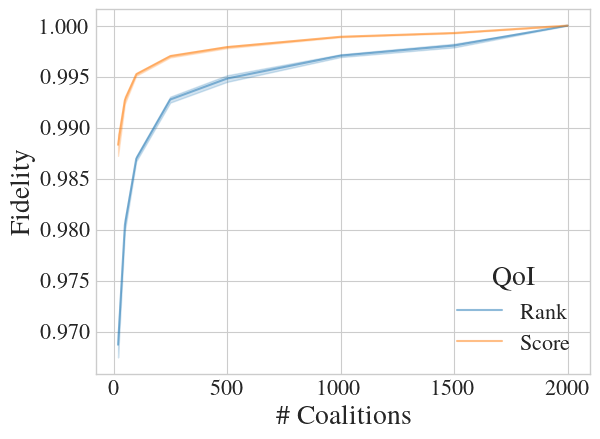

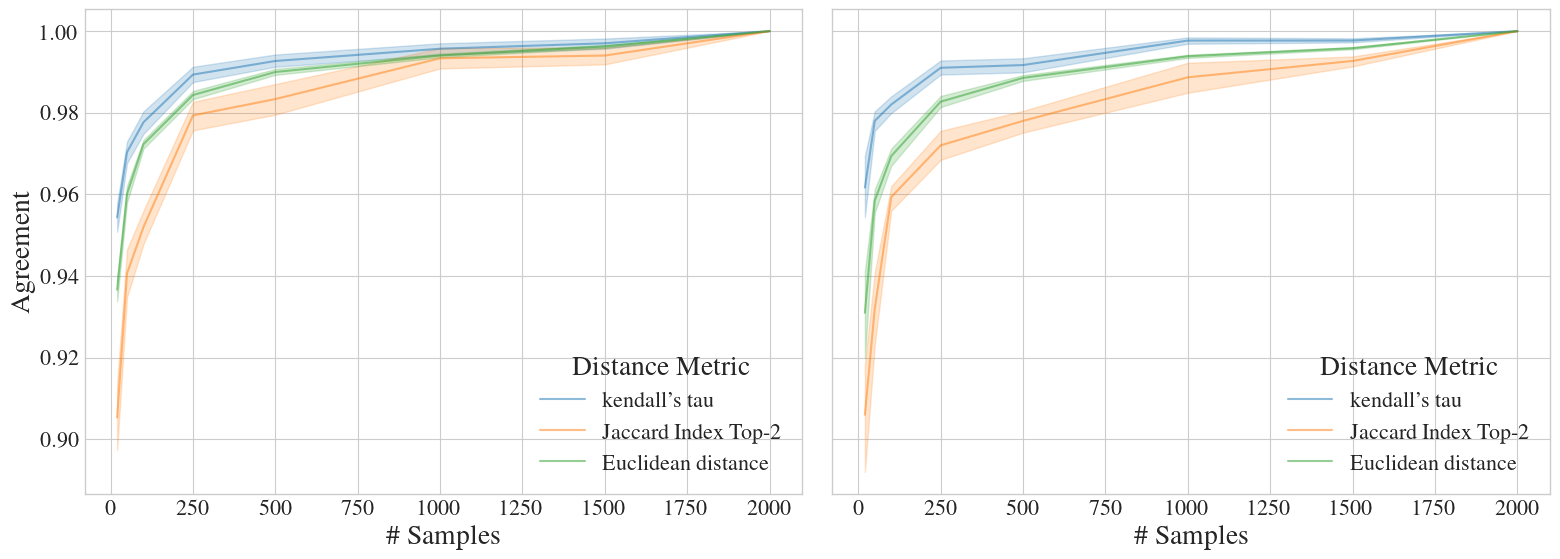

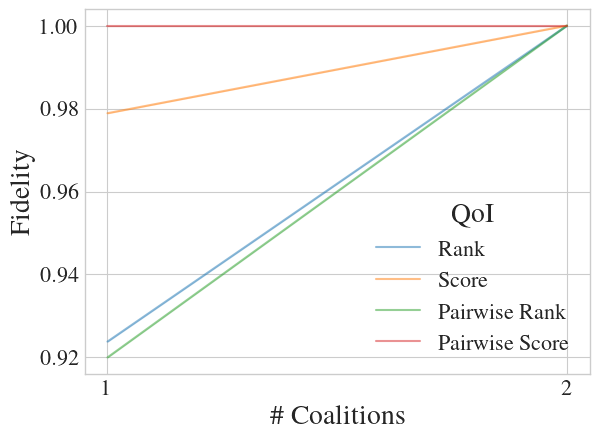

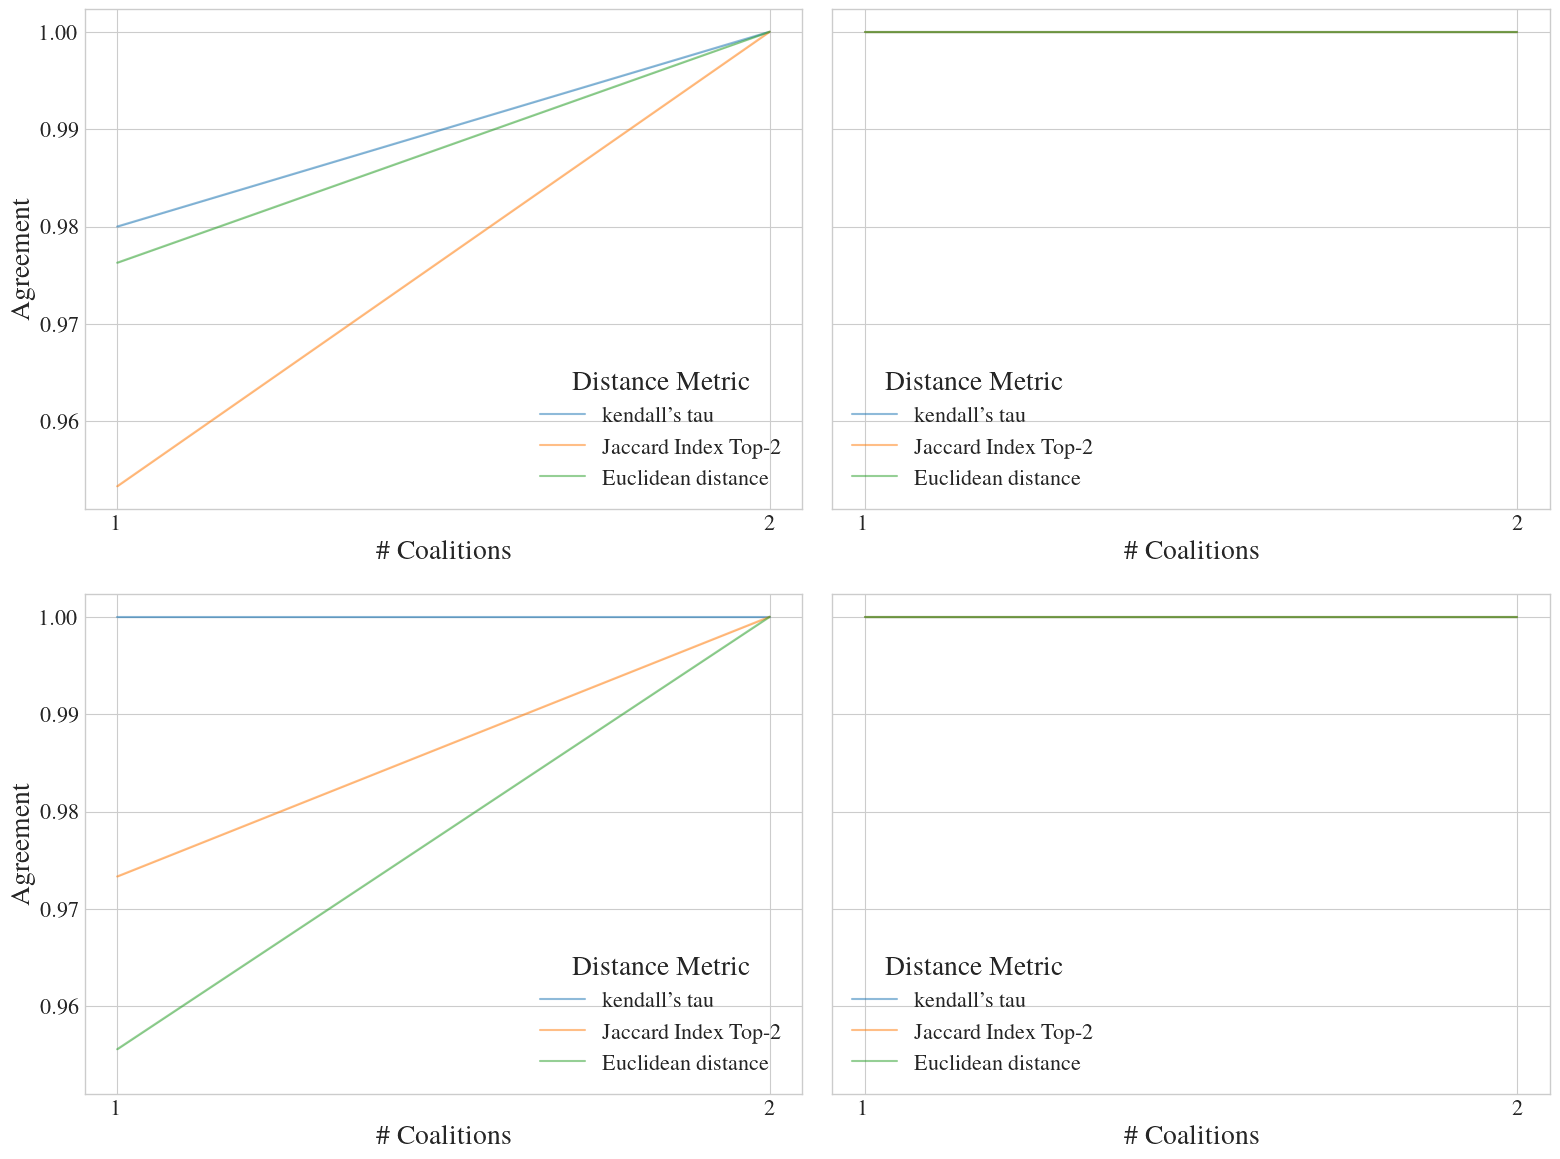

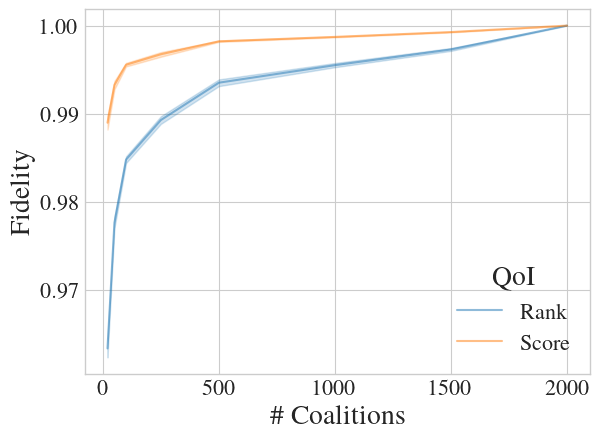

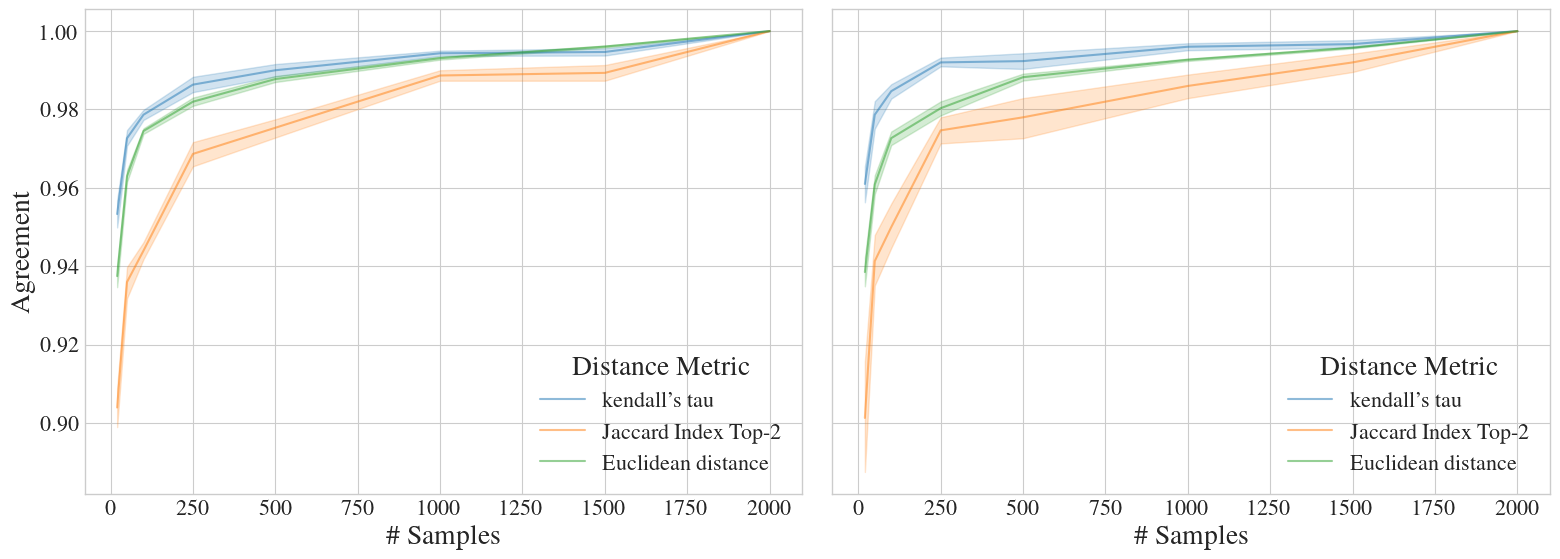

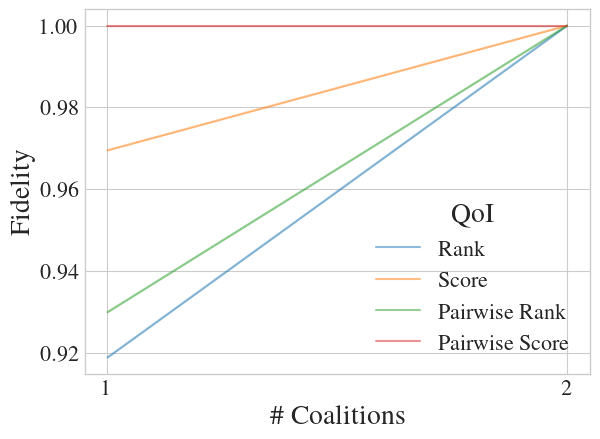

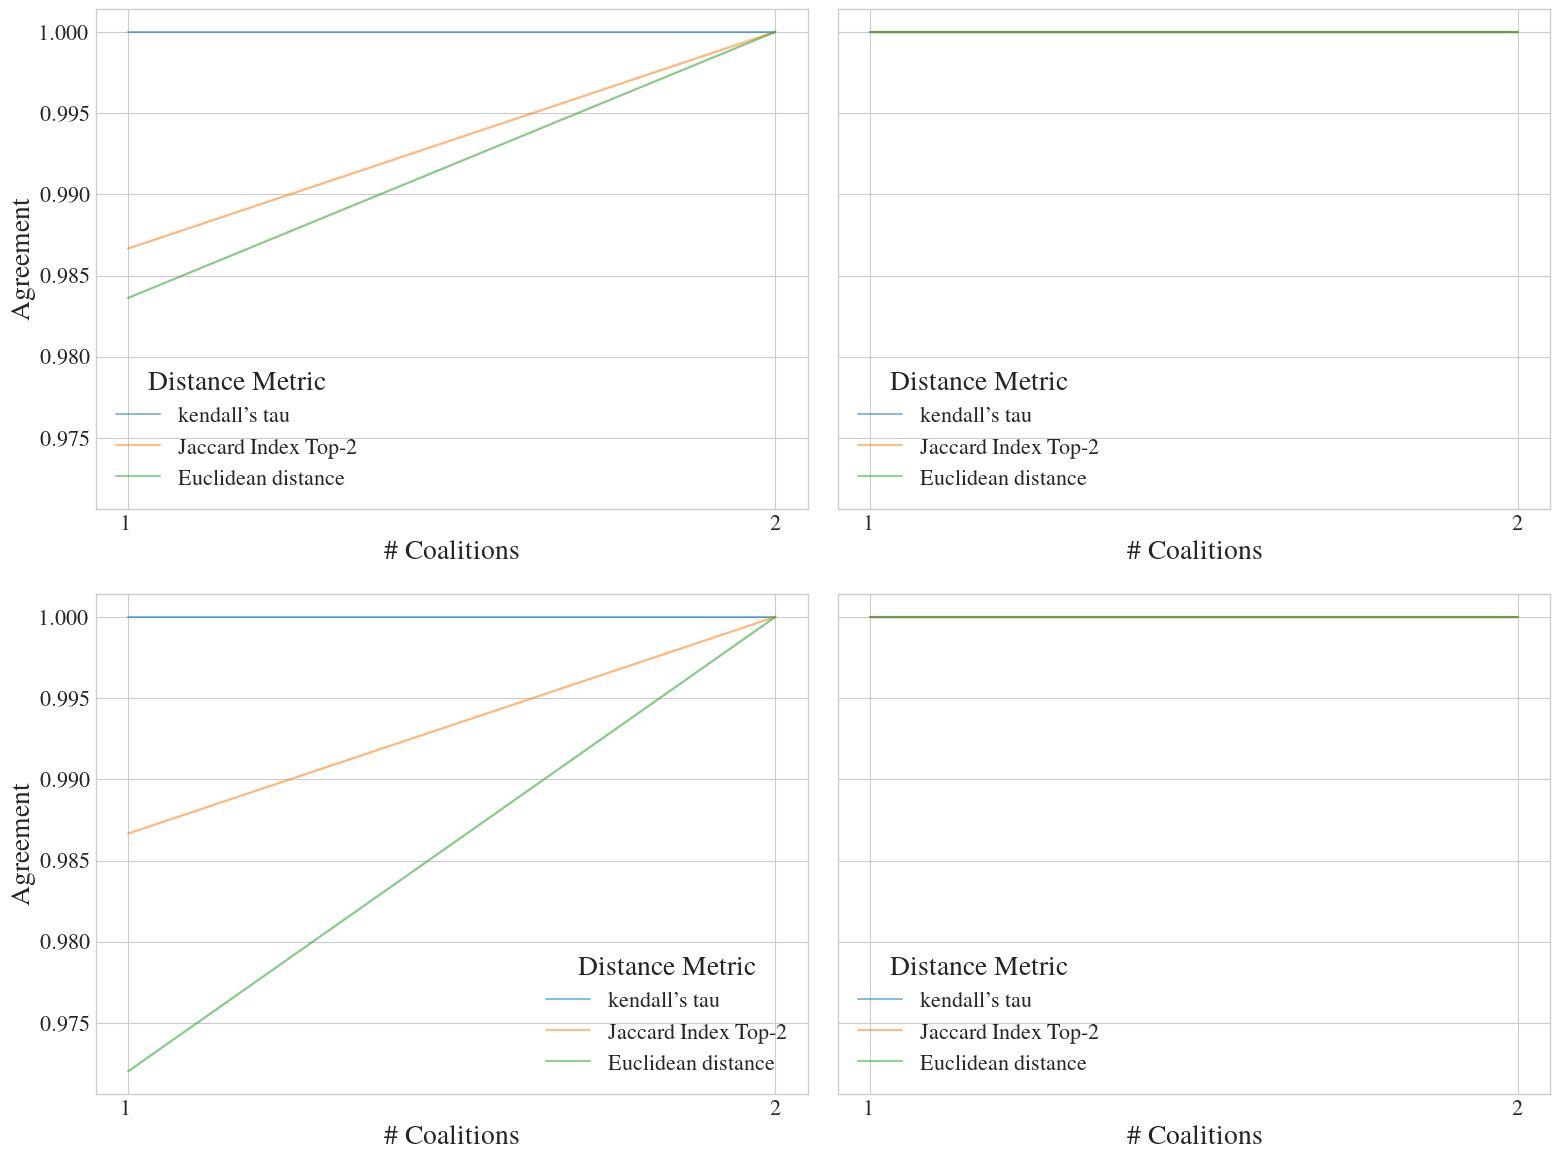

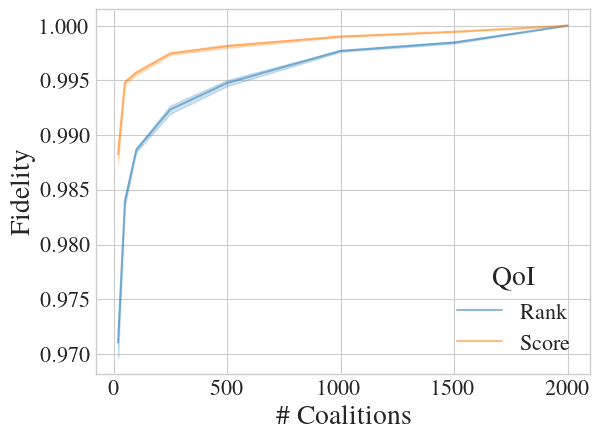

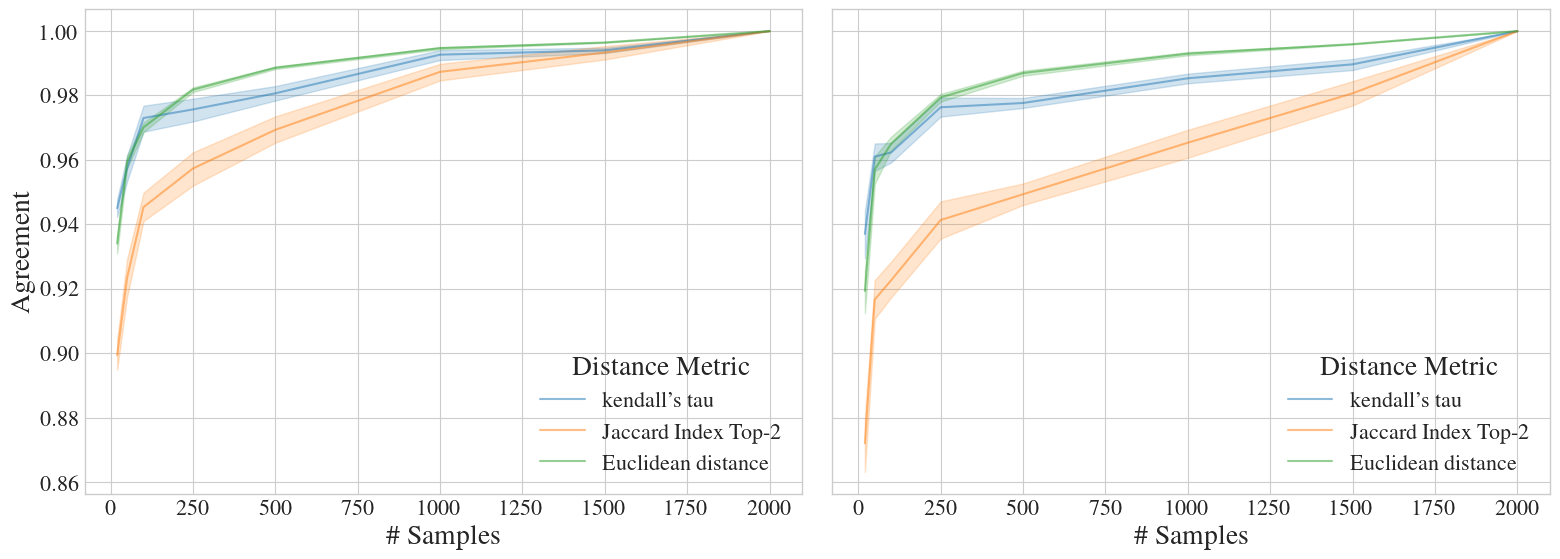

In [11]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    # Plot dataset only
    df = df_all[df_all["dataset"]== dataset["name"]].copy()
    df.rename(columns={"distance metric": "Distance Metric"}, inplace=True)
    df["QoI"] = df.apply(lambda row: "Pairwise " + row["QoI"].capitalize() if row["pairwise"] else row["QoI"].capitalize(), axis=1)
    df.drop(columns=["pairwise"], inplace=True)
    
    for approach, approach_name in zip(["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]):

        # Make plots separately per dataset per approach
        df_coals = df[df["parameter"]==approach].copy()
        df_coals.columns = df.columns.str.replace("#", r"\#")
        # print(df_coals)

        # Fidelity plot 
        if approach == "coalition_size":
            sns.lineplot(x=r"\# coalitions", y="fidelity", hue="QoI", data=df_coals, alpha=0.5)
            plt.xticks(df_coals[r'\# coalitions'].unique().astype(int))
            plt.xlabel(r'\# Coalitions')
            plt.ylabel('Fidelity')
        else:
            sns.lineplot(x=r"\# samples", y="fidelity", hue="QoI", data=df_coals, alpha=0.5)
            plt.xlabel(r'\# Coalitions')
            plt.ylabel('Fidelity')
            # plt.xticks(df_coals['# samples'].unique().astype(int))

        plt.tight_layout()
        plt.savefig(
                f"results/time/plots/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True
                )
        
        # plt.ylabel('Fidelity')
        plt.show()
    
        # Method Agreement
        if approach == "coalition_size":
            fig, ax = plt.subplots(nrows=2, ncols=2, sharey='all', figsize=(16, 12))
            x_var = r"\# coalitions"
        else:
            fig, ax = plt.subplots(nrows=1, ncols=2, sharey='all', figsize=(16, 6))
            x_var = r"\# samples"

        ax = ax.ravel()

        
        # Rank lines
        temp = df_coals[df_coals["QoI"] == "Rank"]
        sns.lineplot(x=x_var, y="agreement", hue="Distance Metric", data=temp, ax=ax[0], alpha=0.5)
        ax[0].set_xlabel(x_var.title())
        plt.ylabel('Agreement')
        # ax[0].set_ylabel('Method Agreement')

        # Score lines
        temp = df_coals[df_coals["QoI"] == "Score"]
        sns.lineplot(x=x_var, y="agreement", hue="Distance Metric", data=temp, ax=ax[1], alpha=0.5)
        ax[1].set_xlabel(x_var.title())
        # ax[1].set_ylabel('Method Agreement')


        # Pairwise lines
        if approach == "coalition_size":
            # Rank lines
            temp = df_coals[df_coals["QoI"] == "Pairwise Rank"]
            sns.lineplot(x=x_var, y="agreement", hue="Distance Metric", data=temp, ax=ax[2], alpha=0.5)
            ax[2].set_xlabel(x_var.title())
            # ax[2].set_ylabel('Method Agreement')
    
            # Score lines
            temp = df_coals[df_coals["QoI"] == "Pairwise Score"]
            sns.lineplot(x=x_var, y="agreement", hue="Distance Metric", data=temp, ax=ax[3], alpha=0.5)
            ax[3].set_xlabel(x_var.title())
            # ax[3].set_ylabel('Method Agreement')

        for i, axis in enumerate(ax):
            if approach == "coalition_size":
                axis.set_xticks(df_coals[x_var].unique().astype(int))
            # else:
            #     axis.set_xticklabels(axis.get_xticklabels(), rotation=40, ha="right")
            if i % 2 == 0:
                axis.set_ylabel('Agreement')
            else:
                axis.set_ylabel('')

        # plt.legend(title='Metric')
        plt.tight_layout()
        plt.savefig(
                f"results/time/plots/time-experiment-{approach}-agreement-{dataset["name"]}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True
                )
        
        plt.show()

In [12]:
# methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

# for dataset in datasets:
#     # Plot dataset only
#     df = df_all[df_all["dataset"]== dataset["name"]]
    
#     for approach, approach_name in zip(["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]):

        # Make plots separately per dataset per approach
        # df_coals = df[df["parameter"]==approach]
        # # average fidelity
        # df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
        # # average agreement
        # df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4']].mean(axis=1)
        # df_coals['average_agreement_jaccard'] = df_coals[['agreement_jaccard2_0', 'agreement_jaccard2_1', 'agreement_jaccard2_2', 'agreement_jaccard2_3', 'agreement_jaccard2_4']].mean(axis=1)
        # df_coals['average_agreement_euclidean'] = df_coals[['agreement_euclidean_0', 'agreement_euclidean_1', 'agreement_euclidean_2', 'agreement_euclidean_3', 'agreement_euclidean_4']].mean(axis=1)
    
        # # Fidelity plot 
        # plt.plot(df_coals[df_coals["approach"]=="rank"]['parameter_value'], df_coals[df_coals["approach"]=="rank"]['average_fidelity'], marker='o', label='rank',alpha=0.5)
        # plt.plot(df_coals[df_coals["approach"]=="score"]['parameter_value'], df_coals[df_coals["approach"]=="score"]['average_fidelity'], marker='o', label='score',alpha=0.5)
        # if approach == "coalition_size":
        #     plt.plot(df_coals[df_coals["approach"]=="pairwise rank"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise rank"]['average_fidelity'], marker='o', label='pairwise rank',alpha=0.5)
        #     plt.plot(df_coals[df_coals["approach"]=="pairwise score"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise score"]['average_fidelity'], marker='o', label='pairwise score',alpha=0.5)

        
        # plt.xlabel(approach_name)
        # plt.ylabel('Method Fidelity')
        # # plt.title(f'{approach_name} vs Fidelity for {dataset["name"]}')
        # plt.legend(title='QoI')
        # if approach == "coalition_size":
        #     plt.xticks(df_coals['parameter_value'].unique().astype(int))
        
        # # plt.xticks(coalition_data['parameter_value'].unique().astype(int))
    
        # plt.savefig(
        #         f"results/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
        #         format="pdf",
        #         bbox_inches="tight",
        #         transparent=True
        #         )
        
        # plt.show()
    
        # # Method Agreement
        # if approach == "coalition_size":
        #     fig, ax = plt.subplots(nrows=2, ncols=2, sharey='row', figsize=(16, 12))
        # else:
        #     fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(16, 6))

        # ax = ax.ravel()
        
        # # Rank lines
        # for agreement in ['kendall', 'jaccard', 'euclidean']:
        #     ax[0].plot(df_coals[df_coals["approach"]=="rank"]['parameter_value'], df_coals[df_coals["approach"]=="rank"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)

        # ax[0].set_xlabel(approach_name)
        # ax[0].set_ylabel('Method Agreement')
        # if approach == "coalition_size":
        #     ax[0].set_xticks(df_coals['parameter_value'].unique().astype(int))
        
        
        # # Score lines
        # for agreement in ['kendall', 'jaccard', 'euclidean']:
        #     ax[1].plot(df_coals[df_coals["approach"]=="score"]['parameter_value'], df_coals[df_coals["approach"]=="score"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)

        # ax[1].yaxis.set_tick_params(which='both', labelleft=True)
        # ax[1].set_xlabel(approach_name)
        # ax[1].set_ylabel('Method Agreement')
        # if approach == "coalition_size":
        #     ax[1].set_xticks(df_coals['parameter_value'].unique().astype(int))


        # # Pairwise lines
        # if approach == "coalition_size":
        #     for agreement in ['kendall', 'jaccard', 'euclidean']:
        #         ax[2].plot(df_coals[df_coals["approach"]=="pairwise rank"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise rank"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)
    
        #     ax[2].yaxis.set_tick_params(which='both', labelleft=True)
        #     ax[2].set_xlabel(approach_name)
        #     ax[2].set_ylabel('Method Agreement')
        #     ax[2].set_xticks(df_coals['parameter_value'].unique().astype(int))

        #     for agreement in ['kendall', 'jaccard', 'euclidean']:
        #             ax[3].plot(df_coals[df_coals["approach"]=="pairwise score"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise score"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)
        
        #     ax[3].yaxis.set_tick_params(which='both', labelleft=True)
        #     ax[3].set_xlabel(approach_name)
        #     ax[3].set_ylabel('Method Agreement')
        #     ax[3].set_xticks(df_coals['parameter_value'].unique().astype(int))

        
        # # plt.title(f'{approach_name} vs Agreement for {dataset["name"]}')
        # plt.legend(title='Metric')
    
        # plt.savefig(
        #         f"results/time-experiment-{approach}-agreement-{dataset["name"]}.pdf",
        #         format="pdf",
        #         bbox_inches="tight",
        #         transparent=True
        #         )
        
        # plt.show()

# Time vs coalition size

    dataset  total samples             QoI       parameter  # samples  \
30      ATP             83            Rank  coalition_size       86.0   
31      ATP             83            Rank  coalition_size       86.0   
32      ATP             83            Rank  coalition_size       86.0   
33      ATP             83            Rank  coalition_size       86.0   
34      ATP             83            Rank  coalition_size       86.0   
..      ...            ...             ...             ...        ...   
895     ATP             83  Pairwise Score  coalition_size       86.0   
896     ATP             83  Pairwise Score  coalition_size       86.0   
897     ATP             83  Pairwise Score  coalition_size       86.0   
898     ATP             83  Pairwise Score  coalition_size       86.0   
899     ATP             83  Pairwise Score  coalition_size       86.0   

     # coalitions      time      Distance Metric  agreement  fidelity  
30            1.0  0.005774        kendall's tau   

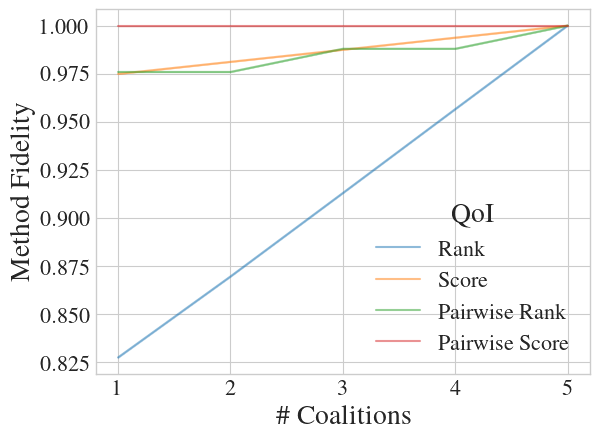

    dataset  total samples    QoI    parameter  # samples  # coalitions  \
180     ATP             83   Rank  sample_size       20.0           5.0   
181     ATP             83   Rank  sample_size       20.0           5.0   
182     ATP             83   Rank  sample_size       20.0           5.0   
183     ATP             83   Rank  sample_size       20.0           5.0   
184     ATP             83   Rank  sample_size       20.0           5.0   
..      ...            ...    ...          ...        ...           ...   
535     ATP             83  Score  sample_size       83.0           5.0   
536     ATP             83  Score  sample_size       83.0           5.0   
537     ATP             83  Score  sample_size       83.0           5.0   
538     ATP             83  Score  sample_size       83.0           5.0   
539     ATP             83  Score  sample_size       83.0           5.0   

         time      Distance Metric  agreement  fidelity  
180  0.008276        kendall's tau   0.97

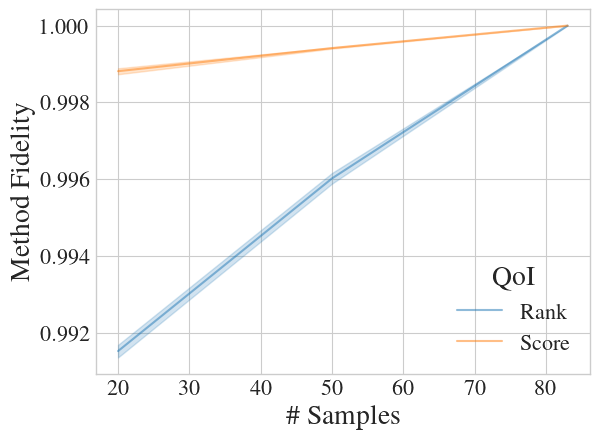

    dataset  total samples             QoI       parameter  # samples  \
30   CSRank            100            Rank  coalition_size      189.0   
31   CSRank            100            Rank  coalition_size      189.0   
32   CSRank            100            Rank  coalition_size      189.0   
33   CSRank            100            Rank  coalition_size      189.0   
34   CSRank            100            Rank  coalition_size      189.0   
..      ...            ...             ...             ...        ...   
715  CSRank            100  Pairwise Score  coalition_size      189.0   
716  CSRank            100  Pairwise Score  coalition_size      189.0   
717  CSRank            100  Pairwise Score  coalition_size      189.0   
718  CSRank            100  Pairwise Score  coalition_size      189.0   
719  CSRank            100  Pairwise Score  coalition_size      189.0   

     # coalitions      time      Distance Metric  agreement  fidelity  
30            1.0  0.014527        kendall's tau   

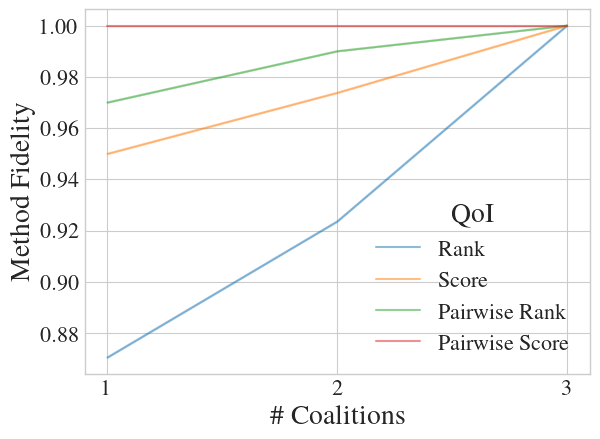

    dataset  total samples    QoI    parameter  # samples  # coalitions  \
120  CSRank            100   Rank  sample_size       20.0           3.0   
121  CSRank            100   Rank  sample_size       20.0           3.0   
122  CSRank            100   Rank  sample_size       20.0           3.0   
123  CSRank            100   Rank  sample_size       20.0           3.0   
124  CSRank            100   Rank  sample_size       20.0           3.0   
..      ...            ...    ...          ...        ...           ...   
475  CSRank            100  Score  sample_size      181.0           3.0   
476  CSRank            100  Score  sample_size      181.0           3.0   
477  CSRank            100  Score  sample_size      181.0           3.0   
478  CSRank            100  Score  sample_size      181.0           3.0   
479  CSRank            100  Score  sample_size      181.0           3.0   

         time      Distance Metric  agreement  fidelity  
120  0.004450        kendall's tau   0.94

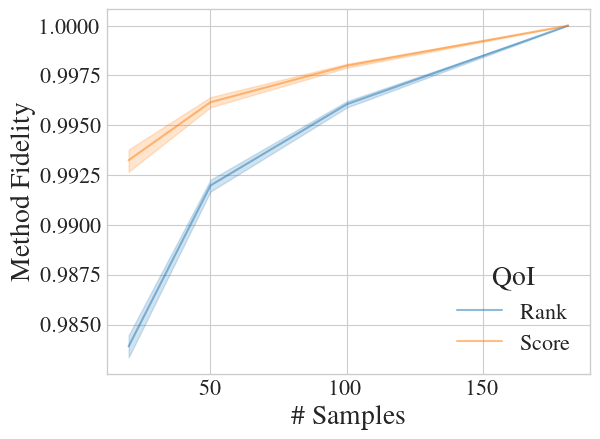

               dataset  total samples             QoI       parameter  \
30    Higher Education            100            Rank  coalition_size   
31    Higher Education            100            Rank  coalition_size   
32    Higher Education            100            Rank  coalition_size   
33    Higher Education            100            Rank  coalition_size   
34    Higher Education            100            Rank  coalition_size   
...                ...            ...             ...             ...   
1015  Higher Education            100  Pairwise Score  coalition_size   
1016  Higher Education            100  Pairwise Score  coalition_size   
1017  Higher Education            100  Pairwise Score  coalition_size   
1018  Higher Education            100  Pairwise Score  coalition_size   
1019  Higher Education            100  Pairwise Score  coalition_size   

      # samples  # coalitions      time      Distance Metric  agreement  \
30       1397.0           1.0  0.160358        k

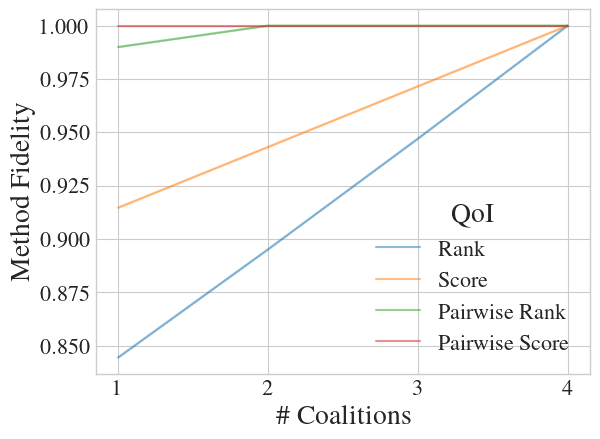

              dataset  total samples    QoI    parameter  # samples  \
150  Higher Education            100   Rank  sample_size       20.0   
151  Higher Education            100   Rank  sample_size       20.0   
152  Higher Education            100   Rank  sample_size       20.0   
153  Higher Education            100   Rank  sample_size       20.0   
154  Higher Education            100   Rank  sample_size       20.0   
..                ...            ...    ...          ...        ...   
715  Higher Education            100  Score  sample_size     1378.0   
716  Higher Education            100  Score  sample_size     1378.0   
717  Higher Education            100  Score  sample_size     1378.0   
718  Higher Education            100  Score  sample_size     1378.0   
719  Higher Education            100  Score  sample_size     1378.0   

     # coalitions      time      Distance Metric  agreement  fidelity  
150           4.0  0.014469        kendall's tau   0.978000  0.991616  
151

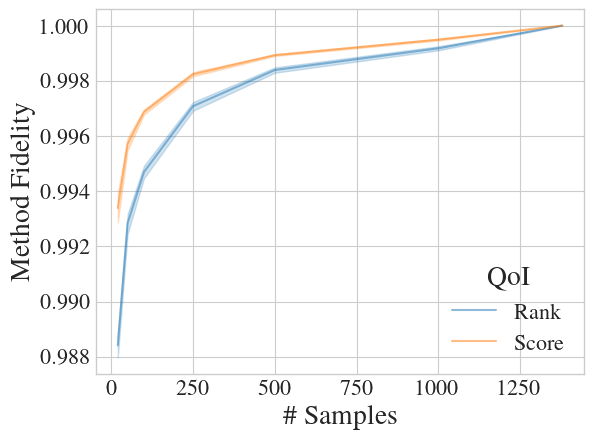

         dataset  total samples             QoI       parameter  # samples  \
30   Synthetic_2            100            Rank  coalition_size     2000.0   
31   Synthetic_2            100            Rank  coalition_size     2000.0   
32   Synthetic_2            100            Rank  coalition_size     2000.0   
33   Synthetic_2            100            Rank  coalition_size     2000.0   
34   Synthetic_2            100            Rank  coalition_size     2000.0   
..           ...            ...             ...             ...        ...   
835  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   
836  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   
837  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   
838  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   
839  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   

     # coalitions      time      Distance Metric  agreement  fi

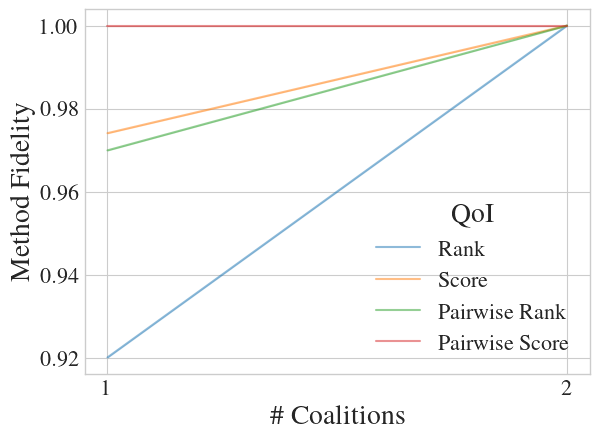

         dataset  total samples    QoI    parameter  # samples  # coalitions  \
90   Synthetic_2            100   Rank  sample_size       20.0           2.0   
91   Synthetic_2            100   Rank  sample_size       20.0           2.0   
92   Synthetic_2            100   Rank  sample_size       20.0           2.0   
93   Synthetic_2            100   Rank  sample_size       20.0           2.0   
94   Synthetic_2            100   Rank  sample_size       20.0           2.0   
..           ...            ...    ...          ...        ...           ...   
655  Synthetic_2            100  Score  sample_size     2000.0           2.0   
656  Synthetic_2            100  Score  sample_size     2000.0           2.0   
657  Synthetic_2            100  Score  sample_size     2000.0           2.0   
658  Synthetic_2            100  Score  sample_size     2000.0           2.0   
659  Synthetic_2            100  Score  sample_size     2000.0           2.0   

         time      Distance Metric  agr

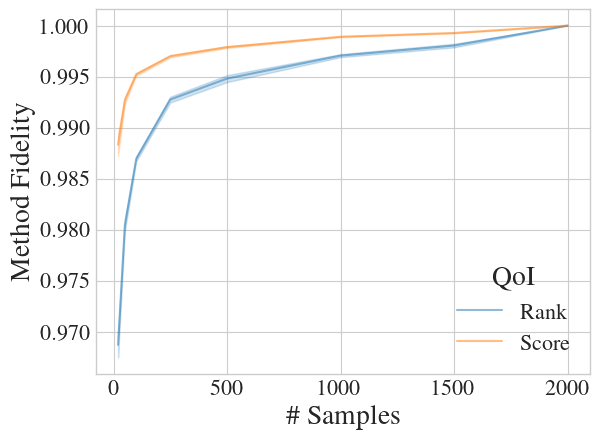

         dataset  total samples             QoI       parameter  # samples  \
30   Synthetic_1            100            Rank  coalition_size     2000.0   
31   Synthetic_1            100            Rank  coalition_size     2000.0   
32   Synthetic_1            100            Rank  coalition_size     2000.0   
33   Synthetic_1            100            Rank  coalition_size     2000.0   
34   Synthetic_1            100            Rank  coalition_size     2000.0   
..           ...            ...             ...             ...        ...   
835  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   
836  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   
837  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   
838  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   
839  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   

     # coalitions      time      Distance Metric  agreement  fi

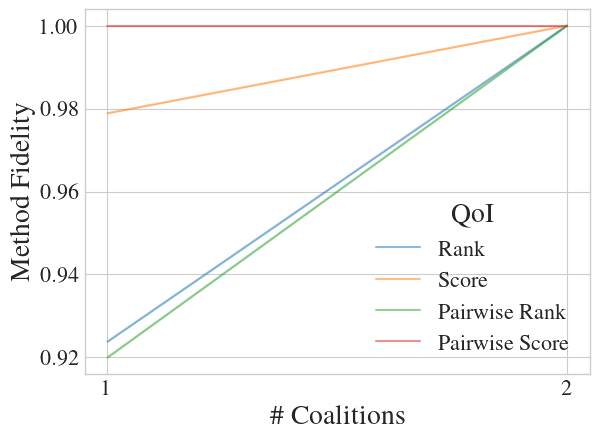

         dataset  total samples    QoI    parameter  # samples  # coalitions  \
90   Synthetic_1            100   Rank  sample_size       20.0           2.0   
91   Synthetic_1            100   Rank  sample_size       20.0           2.0   
92   Synthetic_1            100   Rank  sample_size       20.0           2.0   
93   Synthetic_1            100   Rank  sample_size       20.0           2.0   
94   Synthetic_1            100   Rank  sample_size       20.0           2.0   
..           ...            ...    ...          ...        ...           ...   
655  Synthetic_1            100  Score  sample_size     2000.0           2.0   
656  Synthetic_1            100  Score  sample_size     2000.0           2.0   
657  Synthetic_1            100  Score  sample_size     2000.0           2.0   
658  Synthetic_1            100  Score  sample_size     2000.0           2.0   
659  Synthetic_1            100  Score  sample_size     2000.0           2.0   

         time      Distance Metric  agr

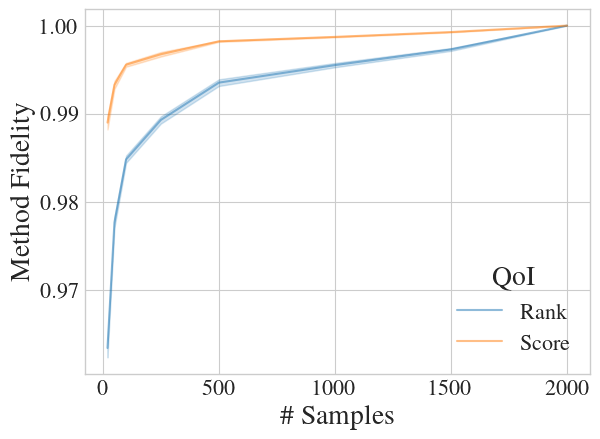

         dataset  total samples             QoI       parameter  # samples  \
30   Synthetic_0            100            Rank  coalition_size     2000.0   
31   Synthetic_0            100            Rank  coalition_size     2000.0   
32   Synthetic_0            100            Rank  coalition_size     2000.0   
33   Synthetic_0            100            Rank  coalition_size     2000.0   
34   Synthetic_0            100            Rank  coalition_size     2000.0   
..           ...            ...             ...             ...        ...   
835  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   
836  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   
837  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   
838  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   
839  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   

     # coalitions      time      Distance Metric  agreement  fi

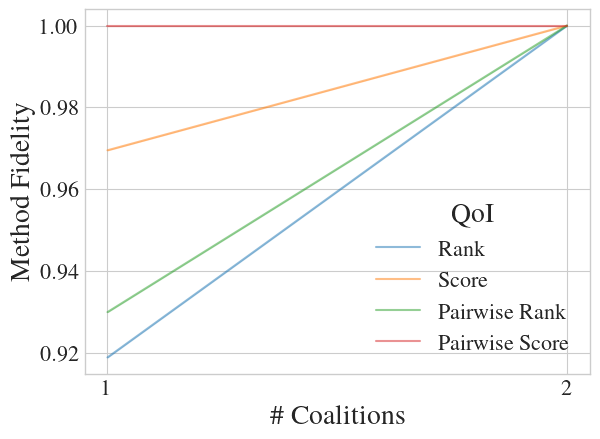

         dataset  total samples    QoI    parameter  # samples  # coalitions  \
90   Synthetic_0            100   Rank  sample_size       20.0           2.0   
91   Synthetic_0            100   Rank  sample_size       20.0           2.0   
92   Synthetic_0            100   Rank  sample_size       20.0           2.0   
93   Synthetic_0            100   Rank  sample_size       20.0           2.0   
94   Synthetic_0            100   Rank  sample_size       20.0           2.0   
..           ...            ...    ...          ...        ...           ...   
655  Synthetic_0            100  Score  sample_size     2000.0           2.0   
656  Synthetic_0            100  Score  sample_size     2000.0           2.0   
657  Synthetic_0            100  Score  sample_size     2000.0           2.0   
658  Synthetic_0            100  Score  sample_size     2000.0           2.0   
659  Synthetic_0            100  Score  sample_size     2000.0           2.0   

         time      Distance Metric  agr

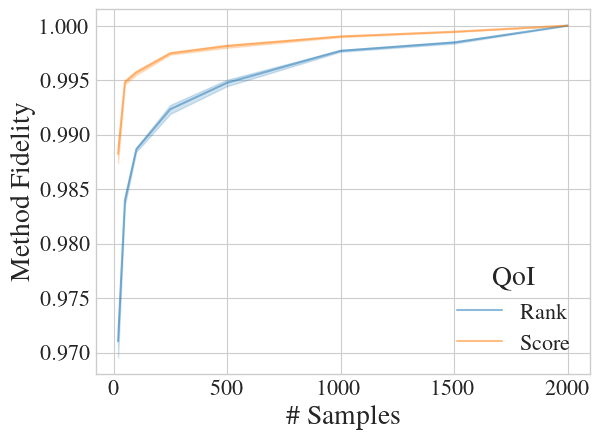

In [13]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    # Plot dataset only
    df = df_all[df_all["dataset"]== dataset["name"]].copy()
    df.rename(columns={"distance metric": "Distance Metric"}, inplace=True)
    df["QoI"] = df.apply(lambda row: "Pairwise " + row["QoI"].capitalize() if row["pairwise"] else row["QoI"].capitalize(), axis=1)
    df.drop(columns=["pairwise"], inplace=True)
    
    for approach, approach_name in zip(["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]):

        # Make plots separately per dataset per approach
        df_coals = df[df["parameter"]==approach]   
        print(df_coals)

        # Fidelity plot 
        if approach == "coalition_size":
            sns.lineplot(x="# coalitions", y="fidelity", hue="QoI", data=df_coals, alpha=0.5)
            plt.xlabel(r"\# Coalitions")
            plt.xticks(df_coals['# coalitions'].unique().astype(int))
        else:
            sns.lineplot(x="# samples", y="fidelity", hue="QoI", data=df_coals, alpha=0.5)
            plt.xlabel(r"\# Samples")
            # plt.xticks(df_coals['# samples'].unique().astype(int))

        plt.tight_layout()
        plt.savefig(
                f"results/time/plots/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True
                )
        
        plt.ylabel('Method Fidelity')
        plt.show()

    dataset  total samples    QoI    parameter  # samples  # coalitions  \
180     ATP             83   Rank  sample_size       20.0           5.0   
181     ATP             83   Rank  sample_size       20.0           5.0   
182     ATP             83   Rank  sample_size       20.0           5.0   
183     ATP             83   Rank  sample_size       20.0           5.0   
184     ATP             83   Rank  sample_size       20.0           5.0   
..      ...            ...    ...          ...        ...           ...   
535     ATP             83  Score  sample_size       83.0           5.0   
536     ATP             83  Score  sample_size       83.0           5.0   
537     ATP             83  Score  sample_size       83.0           5.0   
538     ATP             83  Score  sample_size       83.0           5.0   
539     ATP             83  Score  sample_size       83.0           5.0   

         time      Distance Metric  agreement  fidelity  
180  0.008276        kendall's tau   0.97

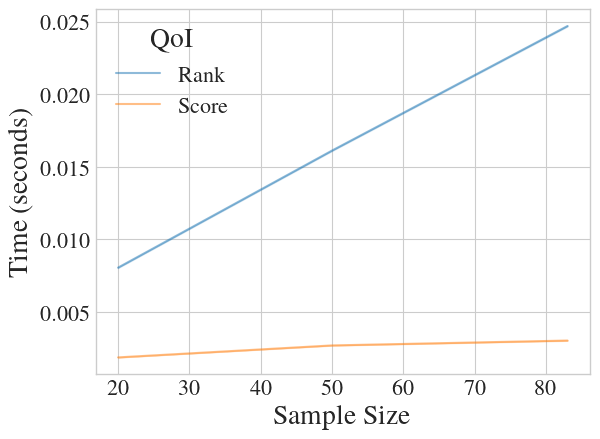

    dataset  total samples             QoI       parameter  # samples  \
30      ATP             83            Rank  coalition_size       86.0   
31      ATP             83            Rank  coalition_size       86.0   
32      ATP             83            Rank  coalition_size       86.0   
33      ATP             83            Rank  coalition_size       86.0   
34      ATP             83            Rank  coalition_size       86.0   
..      ...            ...             ...             ...        ...   
895     ATP             83  Pairwise Score  coalition_size       86.0   
896     ATP             83  Pairwise Score  coalition_size       86.0   
897     ATP             83  Pairwise Score  coalition_size       86.0   
898     ATP             83  Pairwise Score  coalition_size       86.0   
899     ATP             83  Pairwise Score  coalition_size       86.0   

     # coalitions      time      Distance Metric  agreement  fidelity  
30            1.0  0.005774        kendall's tau   

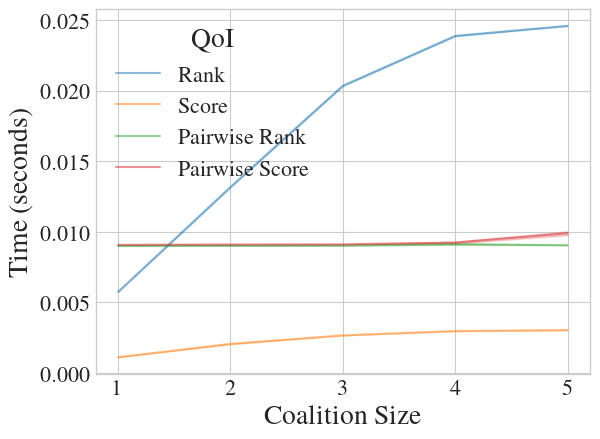

    dataset  total samples    QoI    parameter  # samples  # coalitions  \
120  CSRank            100   Rank  sample_size       20.0           3.0   
121  CSRank            100   Rank  sample_size       20.0           3.0   
122  CSRank            100   Rank  sample_size       20.0           3.0   
123  CSRank            100   Rank  sample_size       20.0           3.0   
124  CSRank            100   Rank  sample_size       20.0           3.0   
..      ...            ...    ...          ...        ...           ...   
475  CSRank            100  Score  sample_size      181.0           3.0   
476  CSRank            100  Score  sample_size      181.0           3.0   
477  CSRank            100  Score  sample_size      181.0           3.0   
478  CSRank            100  Score  sample_size      181.0           3.0   
479  CSRank            100  Score  sample_size      181.0           3.0   

         time      Distance Metric  agreement  fidelity  
120  0.004450        kendall's tau   0.94

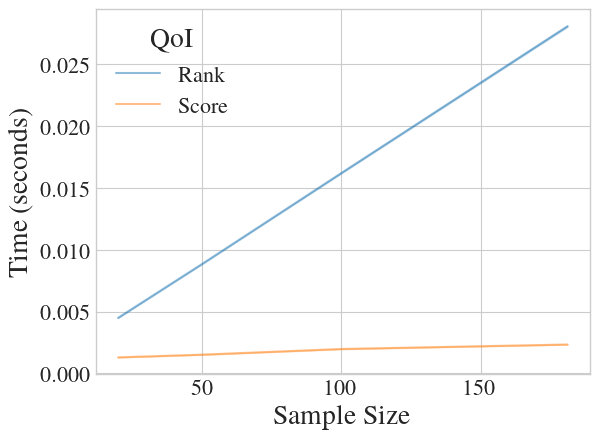

    dataset  total samples             QoI       parameter  # samples  \
30   CSRank            100            Rank  coalition_size      189.0   
31   CSRank            100            Rank  coalition_size      189.0   
32   CSRank            100            Rank  coalition_size      189.0   
33   CSRank            100            Rank  coalition_size      189.0   
34   CSRank            100            Rank  coalition_size      189.0   
..      ...            ...             ...             ...        ...   
715  CSRank            100  Pairwise Score  coalition_size      189.0   
716  CSRank            100  Pairwise Score  coalition_size      189.0   
717  CSRank            100  Pairwise Score  coalition_size      189.0   
718  CSRank            100  Pairwise Score  coalition_size      189.0   
719  CSRank            100  Pairwise Score  coalition_size      189.0   

     # coalitions      time      Distance Metric  agreement  fidelity  
30            1.0  0.014527        kendall's tau   

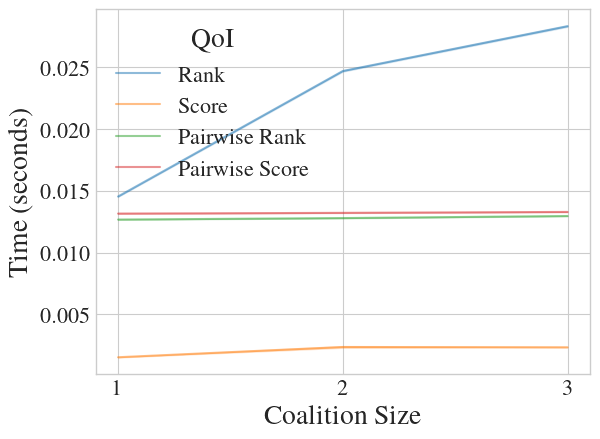

              dataset  total samples    QoI    parameter  # samples  \
150  Higher Education            100   Rank  sample_size       20.0   
151  Higher Education            100   Rank  sample_size       20.0   
152  Higher Education            100   Rank  sample_size       20.0   
153  Higher Education            100   Rank  sample_size       20.0   
154  Higher Education            100   Rank  sample_size       20.0   
..                ...            ...    ...          ...        ...   
715  Higher Education            100  Score  sample_size     1378.0   
716  Higher Education            100  Score  sample_size     1378.0   
717  Higher Education            100  Score  sample_size     1378.0   
718  Higher Education            100  Score  sample_size     1378.0   
719  Higher Education            100  Score  sample_size     1378.0   

     # coalitions      time      Distance Metric  agreement  fidelity  
150           4.0  0.014469        kendall's tau   0.978000  0.991616  
151

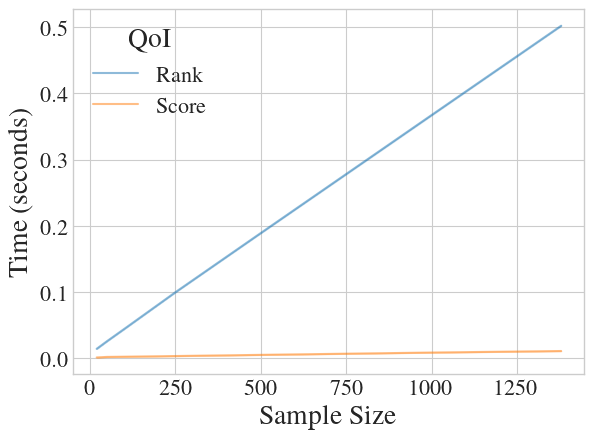

               dataset  total samples             QoI       parameter  \
30    Higher Education            100            Rank  coalition_size   
31    Higher Education            100            Rank  coalition_size   
32    Higher Education            100            Rank  coalition_size   
33    Higher Education            100            Rank  coalition_size   
34    Higher Education            100            Rank  coalition_size   
...                ...            ...             ...             ...   
1015  Higher Education            100  Pairwise Score  coalition_size   
1016  Higher Education            100  Pairwise Score  coalition_size   
1017  Higher Education            100  Pairwise Score  coalition_size   
1018  Higher Education            100  Pairwise Score  coalition_size   
1019  Higher Education            100  Pairwise Score  coalition_size   

      # samples  # coalitions      time      Distance Metric  agreement  \
30       1397.0           1.0  0.160358        k

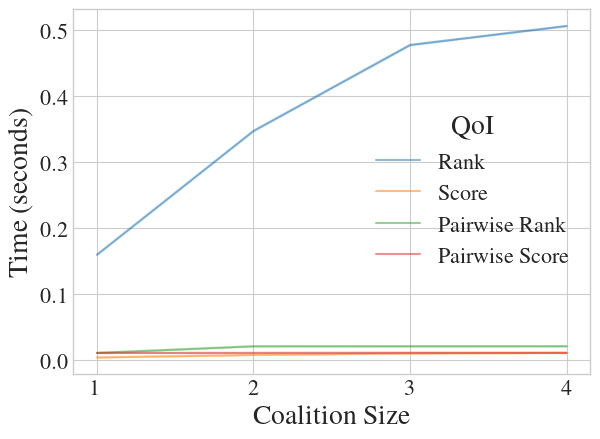

         dataset  total samples    QoI    parameter  # samples  # coalitions  \
90   Synthetic_2            100   Rank  sample_size       20.0           2.0   
91   Synthetic_2            100   Rank  sample_size       20.0           2.0   
92   Synthetic_2            100   Rank  sample_size       20.0           2.0   
93   Synthetic_2            100   Rank  sample_size       20.0           2.0   
94   Synthetic_2            100   Rank  sample_size       20.0           2.0   
..           ...            ...    ...          ...        ...           ...   
655  Synthetic_2            100  Score  sample_size     2000.0           2.0   
656  Synthetic_2            100  Score  sample_size     2000.0           2.0   
657  Synthetic_2            100  Score  sample_size     2000.0           2.0   
658  Synthetic_2            100  Score  sample_size     2000.0           2.0   
659  Synthetic_2            100  Score  sample_size     2000.0           2.0   

         time      Distance Metric  agr

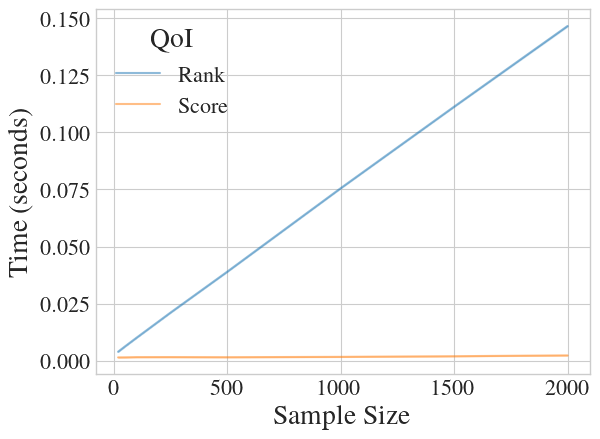

         dataset  total samples             QoI       parameter  # samples  \
30   Synthetic_2            100            Rank  coalition_size     2000.0   
31   Synthetic_2            100            Rank  coalition_size     2000.0   
32   Synthetic_2            100            Rank  coalition_size     2000.0   
33   Synthetic_2            100            Rank  coalition_size     2000.0   
34   Synthetic_2            100            Rank  coalition_size     2000.0   
..           ...            ...             ...             ...        ...   
835  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   
836  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   
837  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   
838  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   
839  Synthetic_2            100  Pairwise Score  coalition_size     2000.0   

     # coalitions      time      Distance Metric  agreement  fi

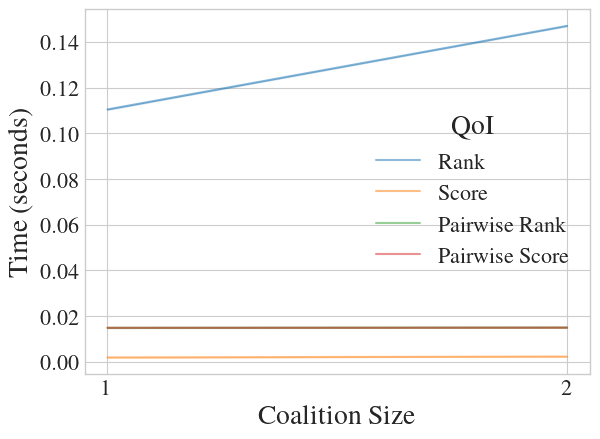

         dataset  total samples    QoI    parameter  # samples  # coalitions  \
90   Synthetic_1            100   Rank  sample_size       20.0           2.0   
91   Synthetic_1            100   Rank  sample_size       20.0           2.0   
92   Synthetic_1            100   Rank  sample_size       20.0           2.0   
93   Synthetic_1            100   Rank  sample_size       20.0           2.0   
94   Synthetic_1            100   Rank  sample_size       20.0           2.0   
..           ...            ...    ...          ...        ...           ...   
655  Synthetic_1            100  Score  sample_size     2000.0           2.0   
656  Synthetic_1            100  Score  sample_size     2000.0           2.0   
657  Synthetic_1            100  Score  sample_size     2000.0           2.0   
658  Synthetic_1            100  Score  sample_size     2000.0           2.0   
659  Synthetic_1            100  Score  sample_size     2000.0           2.0   

         time      Distance Metric  agr

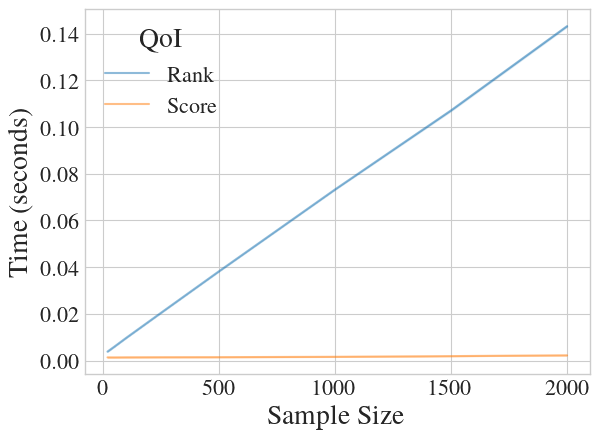

         dataset  total samples             QoI       parameter  # samples  \
30   Synthetic_1            100            Rank  coalition_size     2000.0   
31   Synthetic_1            100            Rank  coalition_size     2000.0   
32   Synthetic_1            100            Rank  coalition_size     2000.0   
33   Synthetic_1            100            Rank  coalition_size     2000.0   
34   Synthetic_1            100            Rank  coalition_size     2000.0   
..           ...            ...             ...             ...        ...   
835  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   
836  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   
837  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   
838  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   
839  Synthetic_1            100  Pairwise Score  coalition_size     2000.0   

     # coalitions      time      Distance Metric  agreement  fi

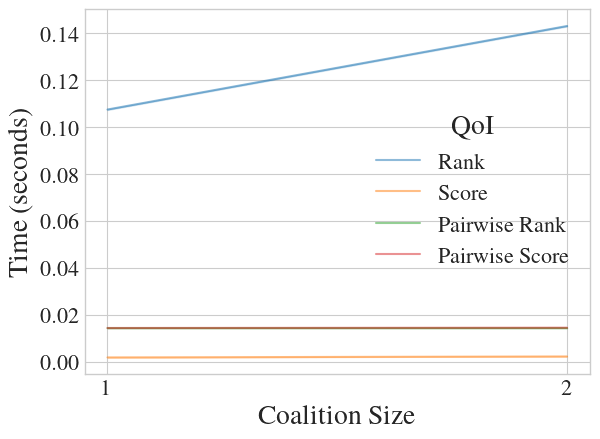

         dataset  total samples    QoI    parameter  # samples  # coalitions  \
90   Synthetic_0            100   Rank  sample_size       20.0           2.0   
91   Synthetic_0            100   Rank  sample_size       20.0           2.0   
92   Synthetic_0            100   Rank  sample_size       20.0           2.0   
93   Synthetic_0            100   Rank  sample_size       20.0           2.0   
94   Synthetic_0            100   Rank  sample_size       20.0           2.0   
..           ...            ...    ...          ...        ...           ...   
655  Synthetic_0            100  Score  sample_size     2000.0           2.0   
656  Synthetic_0            100  Score  sample_size     2000.0           2.0   
657  Synthetic_0            100  Score  sample_size     2000.0           2.0   
658  Synthetic_0            100  Score  sample_size     2000.0           2.0   
659  Synthetic_0            100  Score  sample_size     2000.0           2.0   

         time      Distance Metric  agr

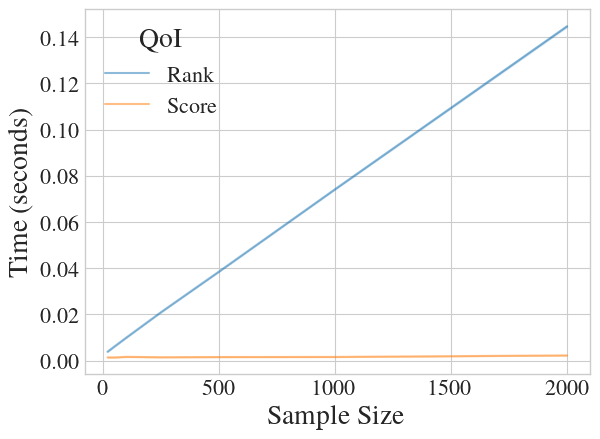

         dataset  total samples             QoI       parameter  # samples  \
30   Synthetic_0            100            Rank  coalition_size     2000.0   
31   Synthetic_0            100            Rank  coalition_size     2000.0   
32   Synthetic_0            100            Rank  coalition_size     2000.0   
33   Synthetic_0            100            Rank  coalition_size     2000.0   
34   Synthetic_0            100            Rank  coalition_size     2000.0   
..           ...            ...             ...             ...        ...   
835  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   
836  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   
837  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   
838  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   
839  Synthetic_0            100  Pairwise Score  coalition_size     2000.0   

     # coalitions      time      Distance Metric  agreement  fi

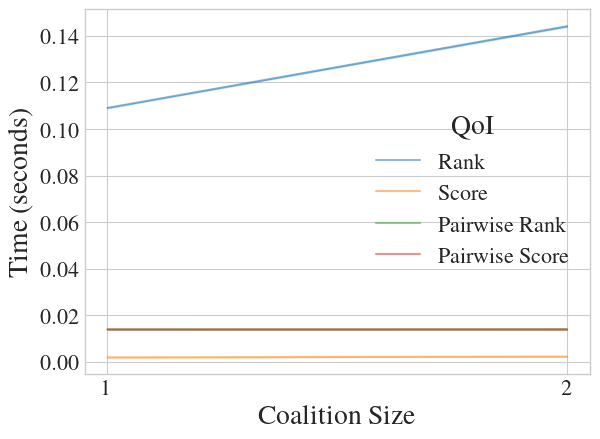

In [14]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    df = df_all[df_all["dataset"]== dataset["name"]].copy()
    df.rename(columns={"distance metric": "Distance Metric"}, inplace=True)
    df["QoI"] = df.apply(lambda row: "Pairwise " + row["QoI"].capitalize() if row["pairwise"] else row["QoI"].capitalize(), axis=1)
    df.drop(columns=["pairwise"], inplace=True)
    
    # Sample plot
    df_samples = df[df["parameter"]=="sample_size"]   
    print(df_samples)
    
    sns.lineplot(x="# samples", y="time", hue="QoI", data=df_samples, alpha=0.5)

    plt.xlabel('Sample Size')
    plt.ylabel('Time (seconds)')
    plt.legend(title='QoI')
    
    plt.tight_layout()
    plt.savefig(
            f"results/time-experiment-timeNsamples-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
    
    plt.show()

    # Coalition plot
    df_coals = df[df["parameter"]=="coalition_size"]   
    print(df_coals)
    
    sns.lineplot(x="# coalitions", y="time", hue="QoI", data=df_coals, alpha=0.5)
    plt.xticks(df_coals['# coalitions'].unique().astype(int))

    plt.xlabel('Coalition Size')
    plt.ylabel('Time (seconds)')
    plt.legend(title='QoI')
    
    plt.tight_layout()
    plt.savefig(
            f"results/time/plots/time-experiment-timeNcoalition-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
    
    plt.show()


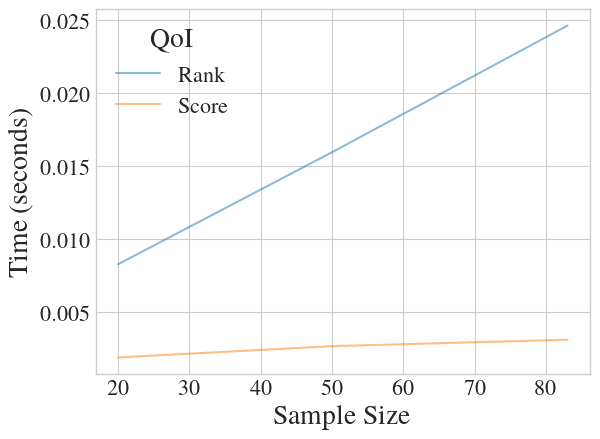

   dataset approach    time_5    time_6    time_7    time_8    time_9  \
6      ATP     Rank  0.801027  0.805884  0.792268  0.817153  0.810798   
7      ATP     Rank  1.627954  1.616464  1.619530  1.610336  1.604064   
8      ATP     Rank  2.451218  2.485454  2.481785  2.458214  2.472388   
15     ATP    Score  0.184500  0.187593  0.187433  0.188761  0.187364   
16     ATP    Score  0.264115  0.267507  0.277887  0.270967  0.270868   
17     ATP    Score  0.310552  0.300948  0.299927  0.297358  0.296554   

    agreement_kendall_5  agreement_kendall_6  agreement_kendall_7  ...  \
6              0.979920             0.974297             0.981526  ...   
7              0.986345             0.987952             0.993574  ...   
8              1.000000             1.000000             1.000000  ...   
15             0.972691             0.975100             0.976707  ...   
16             0.991165             0.991165             0.990361  ...   
17             1.000000             1.000000

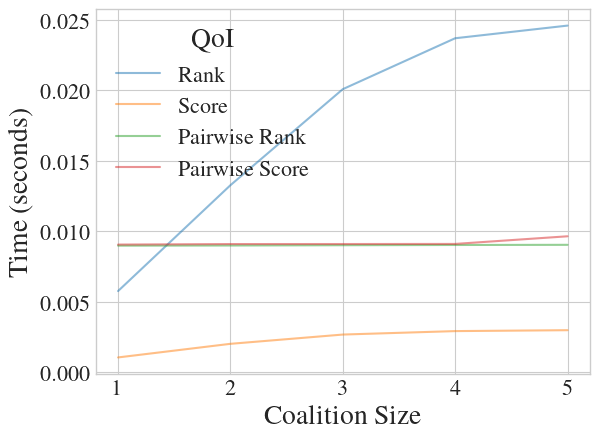

   dataset        approach    time_5    time_6    time_7    time_8    time_9  \
1      ATP            Rank  0.583562  0.563690  0.571571  0.580985  0.576604   
2      ATP            Rank  1.326230  1.296101  1.347687  1.288382  1.331337   
3      ATP            Rank  2.010687  2.050032  2.027760  2.045194  2.057970   
4      ATP            Rank  2.379814  2.367495  2.382977  2.389531  2.385024   
5      ATP            Rank  2.449604  2.444789  2.479417  2.458304  2.465844   
10     ATP           Score  0.109760  0.106203  0.105680  0.114410  0.106891   
11     ATP           Score  0.199466  0.236528  0.194645  0.196427  0.223034   
12     ATP           Score  0.266955  0.267959  0.269193  0.259146  0.273649   
13     ATP           Score  0.305978  0.293902  0.294541  0.301405  0.306609   
14     ATP           Score  0.308916  0.298767  0.307863  0.304391  0.304229   
19     ATP   Pairwise Rank  0.900249  0.901626  0.900712  0.900397  0.900734   
20     ATP   Pairwise Rank  0.900999  0.

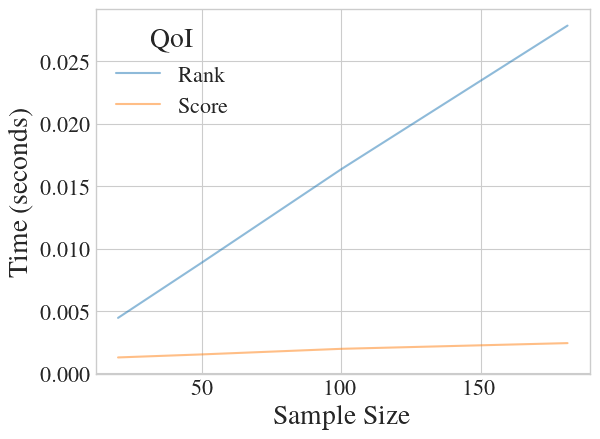

   dataset approach    time_5    time_6    time_7    time_8    time_9  \
4   CSRank     Rank  0.440985  0.445085  0.457140  0.459072  0.451636   
5   CSRank     Rank  0.882455  0.887274  0.878466  0.890074  0.891074   
6   CSRank     Rank  1.611427  1.620027  1.613593  1.649304  1.604316   
7   CSRank     Rank  2.844019  2.781816  2.839763  2.825608  2.834497   
12  CSRank    Score  0.130230  0.128814  0.129054  0.137645  0.131627   
13  CSRank    Score  0.139710  0.152511  0.151307  0.161728  0.142841   
14  CSRank    Score  0.188277  0.189425  0.192925  0.196707  0.190759   
15  CSRank    Score  0.237660  0.232059  0.228335  0.231864  0.230645   

    agreement_kendall_5  agreement_kendall_6  agreement_kendall_7  ...  \
4              0.951667             0.955000             0.958333  ...   
5              0.961667             0.973333             0.981667  ...   
6              0.981667             0.978333             0.986667  ...   
7              1.000000             1.000000  

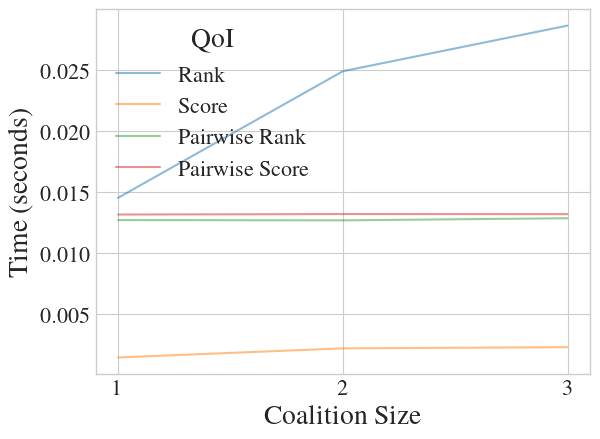

   dataset        approach    time_5    time_6    time_7    time_8    time_9  \
1   CSRank            Rank  1.457661  1.466738  1.435130  1.460736  1.447477   
2   CSRank            Rank  2.473042  2.505918  2.420991  2.459788  2.479620   
3   CSRank            Rank  2.789618  2.834254  2.882901  2.836107  2.830998   
9   CSRank           Score  0.161238  0.148438  0.165126  0.156440  0.141034   
10  CSRank           Score  0.221625  0.231146  0.233467  0.229759  0.328988   
11  CSRank           Score  0.238653  0.232253  0.236105  0.229219  0.228044   
17  CSRank   Pairwise Rank  1.262401  1.261755  1.264575  1.266943  1.270702   
18  CSRank   Pairwise Rank  1.281905  1.291076  1.292237  1.281655  1.284304   
19  CSRank   Pairwise Rank  1.298417  1.297797  1.299208  1.303160  1.298632   
21  CSRank  Pairwise Score  1.313763  1.316536  1.316470  1.321988  1.317671   
22  CSRank  Pairwise Score  1.323483  1.321962  1.325670  1.318741  1.316181   
23  CSRank  Pairwise Score  1.328876  1.

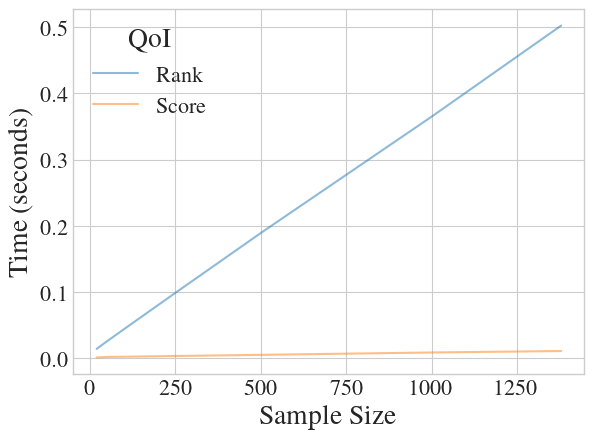

             dataset approach     time_5     time_6     time_7     time_8  \
5   Higher Education     Rank   1.458812   1.502900   1.458435   1.436555   
6   Higher Education     Rank   2.616747   2.645210   2.609128   2.626309   
7   Higher Education     Rank   4.451525   4.358988   4.425992   4.453394   
8   Higher Education     Rank   9.964041   9.955206  10.069331   9.873205   
9   Higher Education     Rank  19.260341  18.896104  18.783383  18.776295   
10  Higher Education     Rank  37.120997  36.642463  36.614870  37.385610   
11  Higher Education     Rank  50.115973  50.088365  50.080133  50.011263   
17  Higher Education    Score   0.157340   0.147231   0.156257   0.158408   
18  Higher Education    Score   0.239197   0.240603   0.228595   0.236766   
19  Higher Education    Score   0.269928   0.256755   0.258996   0.274595   
20  Higher Education    Score   0.367774   0.366025   0.363613   0.373013   
21  Higher Education    Score   0.558807   0.534218   0.530958   0.545150   

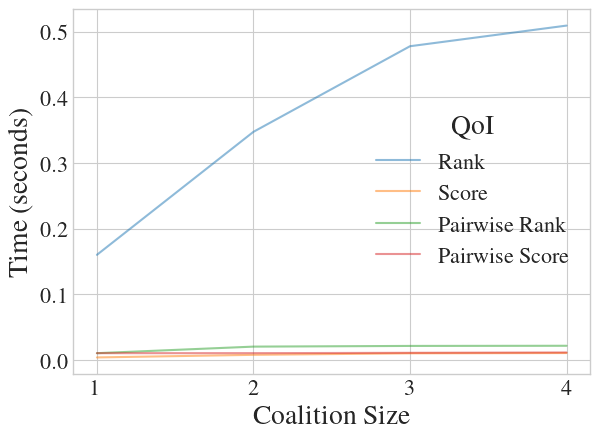

             dataset        approach     time_5     time_6     time_7  \
1   Higher Education            Rank  16.216817  16.007213  15.887120   
2   Higher Education            Rank  34.495609  34.660699  34.643911   
3   Higher Education            Rank  47.880466  47.738833  48.231266   
4   Higher Education            Rank  50.325408  50.380357  50.482729   
13  Higher Education           Score   0.422324   0.425651   0.422112   
14  Higher Education           Score   0.808616   0.814116   0.810175   
15  Higher Education           Score   1.036734   1.041044   1.022980   
16  Higher Education           Score   1.103478   1.107614   1.128097   
25  Higher Education   Pairwise Rank   1.184430   1.073338   1.174380   
26  Higher Education   Pairwise Rank   2.133188   2.112150   2.103547   
27  Higher Education   Pairwise Rank   2.078108   2.187612   2.075083   
28  Higher Education   Pairwise Rank   2.076256   2.178569   2.076460   
30  Higher Education  Pairwise Score   1.153723   1

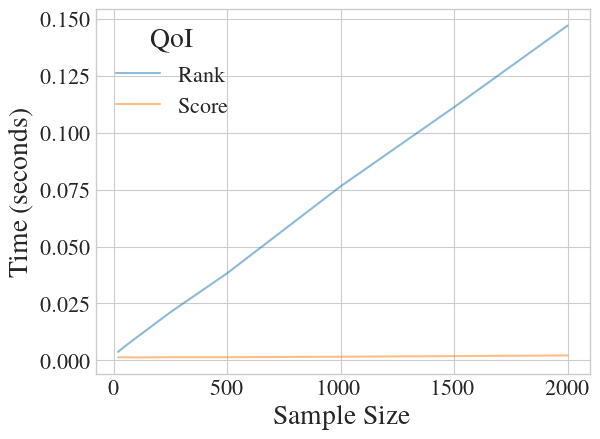

        dataset approach     time_5     time_6     time_7     time_8  \
3   Synthetic_2     Rank   0.377800   0.384688   0.378638   0.390909   
4   Synthetic_2     Rank   0.615813   0.609957   0.616229   0.599891   
5   Synthetic_2     Rank   0.985879   0.975717   0.985540   0.996855   
6   Synthetic_2     Rank   2.066871   2.087930   2.106852   2.083081   
7   Synthetic_2     Rank   3.877631   3.886740   3.915037   3.859178   
8   Synthetic_2     Rank   7.556348   7.554122   7.526190   7.536557   
9   Synthetic_2     Rank  11.102287  11.173185  11.084770  11.161842   
10  Synthetic_2     Rank  14.770104  14.417427  14.694408  14.649171   
14  Synthetic_2    Score   0.129441   0.133036   0.129091   0.134732   
15  Synthetic_2    Score   0.130927   0.140955   0.144637   0.140102   
16  Synthetic_2    Score   0.141354   0.140226   0.157105   0.184001   
17  Synthetic_2    Score   0.137053   0.148122   0.141610   0.140769   
18  Synthetic_2    Score   0.162931   0.139864   0.151907   0.14

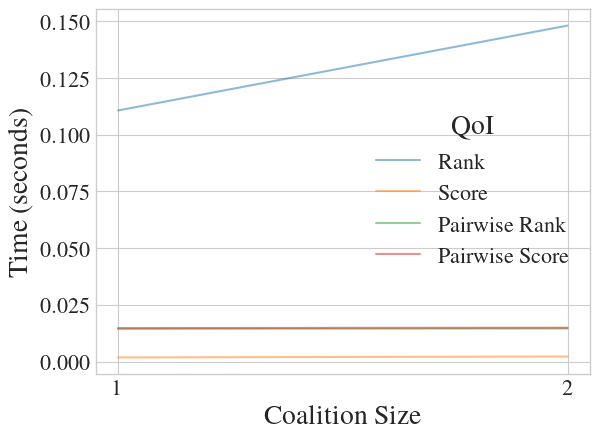

        dataset        approach     time_5     time_6     time_7     time_8  \
1   Synthetic_2            Rank  11.107204  11.197554  11.041510  11.130857   
2   Synthetic_2            Rank  14.796104  14.745578  14.680925  14.636849   
12  Synthetic_2           Score   0.188605   0.187191   0.189067   0.175452   
13  Synthetic_2           Score   0.225463   0.227856   0.216240   0.214186   
23  Synthetic_2   Pairwise Rank   1.519525   1.502515   1.448887   1.485544   
24  Synthetic_2   Pairwise Rank   1.561656   1.465899   1.463388   1.585413   
26  Synthetic_2  Pairwise Score   1.492332   1.474219   1.464006   1.490993   
27  Synthetic_2  Pairwise Score   1.481547   1.482213   1.503009   1.504923   

       time_9  agreement_kendall_5  agreement_kendall_6  agreement_kendall_7  \
1   11.080837             0.993333             0.993333             0.993333   
2   14.580489             1.000000             1.000000             1.000000   
12   0.183216             1.000000             1

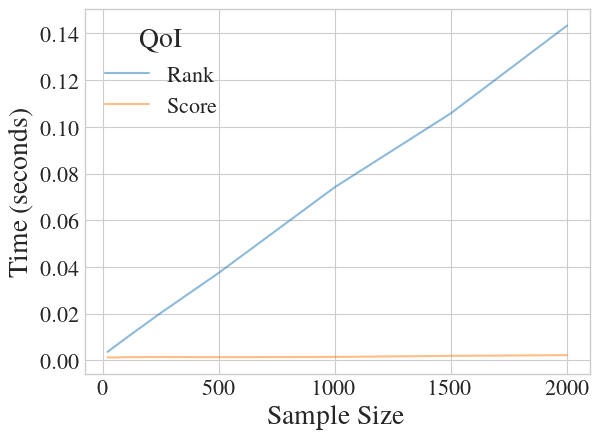

        dataset approach     time_5     time_6     time_7     time_8  \
3   Synthetic_1     Rank   0.379460   0.393759   0.395491   0.377472   
4   Synthetic_1     Rank   0.597171   0.609169   0.601681   0.593806   
5   Synthetic_1     Rank   0.961115   0.949209   0.984328   0.957854   
6   Synthetic_1     Rank   2.065417   2.065034   1.995271   2.013211   
7   Synthetic_1     Rank   3.800656   3.817116   3.794234   3.826995   
8   Synthetic_1     Rank   7.269771   7.295735   7.281792   7.318404   
9   Synthetic_1     Rank  10.656602  10.505814  10.722587  10.555264   
10  Synthetic_1     Rank  14.392953  14.471983  14.363399  14.443471   
14  Synthetic_1    Score   0.131212   0.131263   0.131572   0.151212   
15  Synthetic_1    Score   0.130005   0.144030   0.128535   0.131546   
16  Synthetic_1    Score   0.136023   0.129477   0.143681   0.134714   
17  Synthetic_1    Score   0.150628   0.135686   0.141114   0.141365   
18  Synthetic_1    Score   0.141557   0.153116   0.135888   0.14

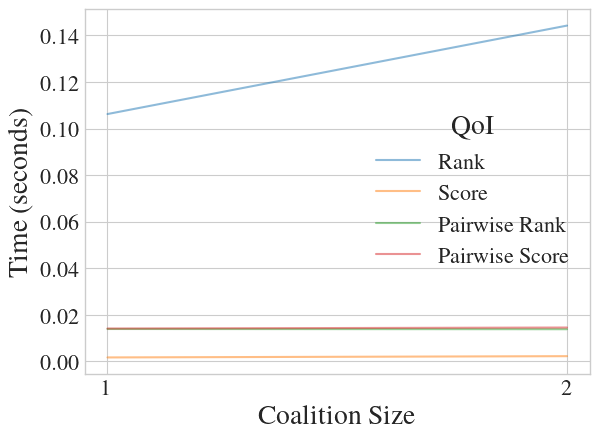

        dataset        approach     time_5     time_6     time_7     time_8  \
1   Synthetic_1            Rank  10.803273  10.848057  10.602399  10.726663   
2   Synthetic_1            Rank  14.349627  14.258093  14.200232  14.443493   
12  Synthetic_1           Score   0.183177   0.183631   0.176476   0.186445   
13  Synthetic_1           Score   0.222207   0.222905   0.219918   0.212150   
23  Synthetic_1   Pairwise Rank   1.458988   1.445863   1.383622   1.440323   
24  Synthetic_1   Pairwise Rank   1.503455   1.391102   1.394772   1.531904   
26  Synthetic_1  Pairwise Score   1.444976   1.420312   1.427608   1.454063   
27  Synthetic_1  Pairwise Score   1.425729   1.427137   1.487255   1.444195   

       time_9  agreement_kendall_5  agreement_kendall_6  agreement_kendall_7  \
1   10.743360                 0.98                 0.98                 0.98   
2   14.275845                 1.00                 1.00                 1.00   
12   0.177591                 1.00              

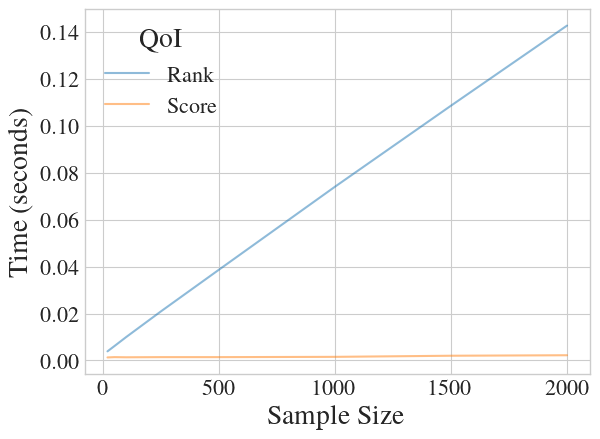

        dataset approach     time_5     time_6     time_7     time_8  \
3   Synthetic_0     Rank   0.374962   0.378093   0.376999   0.391558   
4   Synthetic_0     Rank   0.615124   0.598170   0.614783   0.611868   
5   Synthetic_0     Rank   0.982289   0.980660   0.975458   0.997920   
6   Synthetic_0     Rank   2.080757   2.075646   2.091250   2.072734   
7   Synthetic_0     Rank   3.803425   3.869302   3.900785   3.864480   
8   Synthetic_0     Rank   7.388599   7.266809   7.480991   7.594358   
9   Synthetic_0     Rank  10.890334  10.753615  11.043030  10.779094   
10  Synthetic_0     Rank  14.511358  14.598963  14.567814  14.663438   
14  Synthetic_0    Score   0.130380   0.129828   0.140275   0.138710   
15  Synthetic_0    Score   0.130605   0.144309   0.131016   0.140452   
16  Synthetic_0    Score   0.195944   0.138693   0.148741   0.141749   
17  Synthetic_0    Score   0.141450   0.130633   0.139342   0.143410   
18  Synthetic_0    Score   0.146532   0.144749   0.154506   0.13

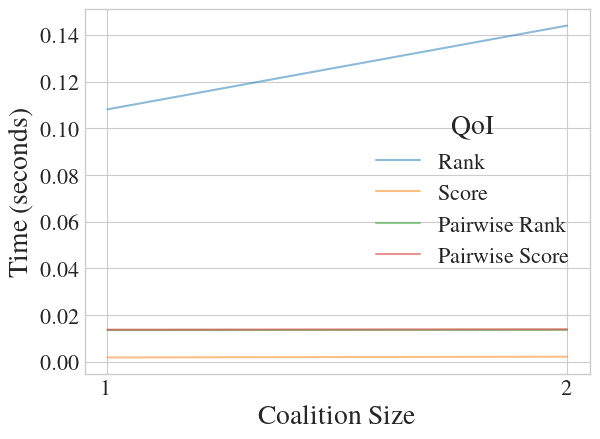

        dataset        approach     time_5     time_6     time_7     time_8  \
1   Synthetic_0            Rank  11.062185  10.865039  10.830774  10.981849   
2   Synthetic_0            Rank  14.342664  14.440960  14.550709  14.417075   
12  Synthetic_0           Score   0.178643   0.181895   0.183974   0.183137   
13  Synthetic_0           Score   0.218150   0.226473   0.228815   0.215199   
23  Synthetic_0   Pairwise Rank   1.425691   1.405161   1.353176   1.398521   
24  Synthetic_0   Pairwise Rank   1.450711   1.361073   1.362608   1.478130   
26  Synthetic_0  Pairwise Score   1.403406   1.371931   1.400852   1.423361   
27  Synthetic_0  Pairwise Score   1.381938   1.383438   1.394289   1.385571   

       time_9  agreement_kendall_5  agreement_kendall_6  agreement_kendall_7  \
1   10.817121                  1.0                  1.0                  1.0   
2   14.589973                  1.0                  1.0                  1.0   
12   0.181553                  1.0              

In [15]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    # Get dataset size
    n_samples = dataset["data"][0].shape[1]
    n_features = dataset["data"][0].shape[0]

    # Sample plot
    df = pd.DataFrame()
    for method in methods:
        # Sample experiments
        tmp = results[dataset["name"]][method][0].copy()
        if not tmp.empty:
            tmp = tmp[tmp["parameter"]=="sample_size"]
            tmp = tmp.dropna()
            tmp["time"] = tmp["time_0"] / 100
            # Set new columns
            tmp["# samples"] = tmp["parameter_value"]
            tmp["# coalitions"] = n_features
            tmp.drop(columns=["time_0", "time_1", "time_2", "time_3", "time_4",
                                "agreement_kendall_0", "agreement_kendall_1",
                                "agreement_kendall_2", "agreement_kendall_3",
                                "agreement_kendall_4", "agreement_jaccard2_0",
                                "agreement_jaccard2_1", "agreement_jaccard2_2",
                                "agreement_jaccard2_3", "agreement_jaccard2_4",
                                "agreement_euclidean_0", "agreement_euclidean_1",
                                "agreement_euclidean_2", "agreement_euclidean_3",
                                "agreement_euclidean_4", "fidelity_0",
                                "fidelity_1", "fidelity_2", "fidelity_3",
                                "fidelity_4", "n_observations", "parameter",
                                "parameter_value", "avg_time"], inplace=True)
            df = pd.concat([df,tmp])
            df = df.replace("rank_score_rank_score", "Score")
            df = df.replace("rank_rank", "Rank")
            df = df.replace("pairwise_rank_score", "Pairwise Score")
            df = df.replace("pairwise_rank", "Pairwise Rank") 

    # Sample plot
    df_coals = df
    plt.plot(df_coals[df_coals["approach"]=="Rank"]['# samples'], df_coals[df_coals["approach"]=="Rank"]['time'], label='Rank', alpha=0.5)
    plt.plot(df_coals[df_coals["approach"]=="Score"]['# samples'], df_coals[df_coals["approach"]=="Score"]['time'], label='Score', alpha=0.5)
  
    plt.xlabel('Sample Size')
    plt.ylabel('Time (seconds)')
    # plt.title(f'{approach_name} vs Fidelity for {dataset["name"]}')
    plt.legend(title='QoI')
  
    # plt.xticks(coalition_data['parameter_value'].unique().astype(int))

    plt.tight_layout()
    plt.savefig(
            f"results/time-experiment-{approach}-timeNsamples-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
  
    plt.show()
  
    print(df)

    # Coalition plot
    df = pd.DataFrame()
    for method in methods:
        # Coalition experiments
        tmp = results[dataset["name"]][method][0].copy()
        if not tmp.empty:
            tmp = tmp[tmp["parameter"]=="coalition_size"]
            tmp = tmp.dropna()
            tmp["time"] = tmp["time_0"] / 100
            # Set new columns
            tmp["# samples"] = n_samples
            tmp["# coalitions"] = tmp["parameter_value"]
            tmp.drop(columns=["time_0", "time_1", "time_2", "time_3", "time_4",
                                "agreement_kendall_0", "agreement_kendall_1",
                                "agreement_kendall_2", "agreement_kendall_3",
                                "agreement_kendall_4", "agreement_jaccard2_0",
                                "agreement_jaccard2_1", "agreement_jaccard2_2",
                                "agreement_jaccard2_3", "agreement_jaccard2_4",
                                "agreement_euclidean_0", "agreement_euclidean_1",
                                "agreement_euclidean_2", "agreement_euclidean_3",
                                "agreement_euclidean_4", "fidelity_0",
                                "fidelity_1", "fidelity_2", "fidelity_3",
                                "fidelity_4", "n_observations", "parameter",
                                "parameter_value", "avg_time"], inplace=True)
            # Make dataset that contains all methods together (if run each QoI separately)
            df = pd.concat([df,tmp])
            df = df.replace("rank_score_rank_score", "Score")
            df = df.replace("rank_rank", "Rank")
            df = df.replace("pairwise_rank_score", "Pairwise Score")
            df = df.replace("pairwise_rank", "Pairwise Rank") 

    # Coalition plot
    df_coals = df
    # df_coals = df_coals[df_coals["# coalitions"] != n_features]
    plt.plot(df_coals[df_coals["approach"]=="Rank"]['# coalitions'], df_coals[df_coals["approach"]=="Rank"]['time'], label='Rank', alpha=0.5)
    plt.plot(df_coals[df_coals["approach"]=="Score"]['# coalitions'], df_coals[df_coals["approach"]=="Score"]['time'], label='Score', alpha=0.5)
    plt.plot(df_coals[df_coals["approach"]=="Pairwise Rank"]['# coalitions'], df_coals[df_coals["approach"]=="Pairwise Rank"]['time'], label='Pairwise Rank', alpha=0.5)
    plt.plot(df_coals[df_coals["approach"]=="Pairwise Score"]['# coalitions'], df_coals[df_coals["approach"]=="Pairwise Score"]['time'], label='Pairwise Score', alpha=0.5)

    plt.xlabel('Coalition Size')
    plt.ylabel('Time (seconds)')
    # plt.title(f'{approach_name} vs Fidelity for {dataset["name"]}')
    plt.legend(title='QoI')
    plt.xticks(df_coals['# coalitions'].unique().astype(int))

    plt.tight_layout()
    plt.savefig(
            f"results/time-experiment-{approach}-timeNcoalition-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
  
    plt.show()
      

    print(df_coals)